# Деревья решений - Decision Trees

# Данные
Будем использовать один и тот же набор данных для всех методов классификации на основе деревьев (Деревья решений - Decision Tree, Случайные леса - Random Forests и Расширяемые деревья - Gradient Boosted Trees). Это позволит сравнивать работу этих методов между собой.

Будем работать с набором данных "Palmer Penguins" - он достаточно простой для того, чтобы можно понять влияние гиперпараметров на результаты классификации.

penguins_size.csv: Упрощённые данные из исходного набора данных о пингвинах. Содержит следующие переменные:

* species: разновидности пингвинов - Антарктический пингвин (Chinstrap), Пингвин Адели (Adélie) или Папуанский пингвин (Gentoo)
* culmen_length_mm: длина клюва (mm)
* culmen_depth_mm: высота клюва (mm)
* flipper_length_mm: длина крыла (mm)
* body_mass_g: масса тела (g)
* island: название острова (Dream, Torgersen или Biscoe) на архипелаге Палмер (Антарктика)
* sex: пол пингвина

**Цель - создать модель, которая поможет определять вид пингвина на основе его физических атрибутов, чтобы исследователи могли с помощью этой модели классифицировать пингвинов, без необходимости привлечения опытного биолога.**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../DATA/penguins_size.csv')
df.head()

species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
3  Adelie  Torgersen               NaN              NaN                NaN   
4  Adelie  Torgersen              36.7             19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE

## Исследование данных - EDA
### Отсутствующие значения - Missing Data
Если какие-то значения отсутствуют и их немного, можно удалить такие данные. Однако для использования будущей модели предполагается, что для новых пингвинов все признаки будут измеряться без пропусков.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Наша модель должна предсказывать колонку *species*

In [9]:
df['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [12]:
# Просуммируем True - как 1, False - как 0
df.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [14]:
# Какой процент данных придётся удалить?
100*(10/344)

2.9069767441860463

In [16]:
df = df.dropna()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


Мы удалили 10 строк из исходного датафрейма. Это было сделано для простоты, но логичнее было бы попытаться заменить отсутствующие значения. Получается, что в тех 10 строках, в которых отсутствовали данные в колонке *sex*, также отсутствовали данные в колонках: *culmen_depth_mm, flipper_length_mm, body_mass_g*. Но это также могли быть разные строки - здесь просто повезло.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [24]:
df.head()

species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
4  Adelie  Torgersen              36.7             19.3              193.0   
5  Adelie  Torgersen              39.3             20.6              190.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
4       3450.0  FEMALE  
5       3650.0    MALE

In [26]:
df['island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [28]:
df['sex'].unique()

array(['MALE', 'FEMALE', '.'], dtype=object)

In [30]:
df[df['sex'] == '.']

species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
336  Gentoo  Biscoe              44.5             15.7              217.0   

     body_mass_g sex  
336       4875.0   .

Для какого-то одного пингвина все колонки, кроме колонки *sex*, правильно заполнены. Можно удалить эту строку, но также можно попробовать понять, какой здесь должен быть пол на основе других колонок для этой конкретной разновидности пингвинов - *Gentoo*.

Выполним группировку по колонке *sex*, чтобы посмотреть отдельно каждую из трёх категорий *male*, *female* и *"."*, после чего вызовем метод `.describe()` - чтобы посмотреть на описательные характеристики.

In [38]:
df[df['species'] == 'Gentoo'].groupby('sex').describe().transpose()

sex                           .       FEMALE         MALE
culmen_length_mm  count     1.0    58.000000    61.000000
                  mean     44.5    45.563793    49.473770
                  std       NaN     2.051247     2.720594
                  min      44.5    40.900000    44.400000
                  25%      44.5    43.850000    48.100000
                  50%      44.5    45.500000    49.500000
                  75%      44.5    46.875000    50.500000
                  max      44.5    50.500000    59.600000
culmen_depth_mm   count     1.0    58.000000    61.000000
                  mean     15.7    14.237931    15.718033
                  std       NaN     0.540249     0.741060
                  min      15.7    13.100000    14.100000
                  25%      15.7    13.800000    15.200000
                  50%      15.7    14.250000    15.700000
                  75%      15.7    14.600000    16.100000
                  max      15.7    15.500000    17.300000
flipper_length_mm count     1.0    58.000000    61.000000
                  mean    217.0   212.706897   221.540984
                  std       NaN     3.897856     5.673252
                  min     217.0   203.000000   208.000000
                  25%     217.0   210.000000   218.000000
                  50%     217.0   212.000000   221.000000
                  75%     217.0   215.000000   225.000000
                  max     217.0   222.000000   231.000000
body_mass_g       count     1.0    58.000000    61.000000
                  mean   4875.0  4679.741379  5484.836066
                  std       NaN   281.578294   313.158596
                  min    4875.0  3950.000000  4750.000000
                  25%    4875.0  4462.500000  5300.000000
                  50%    4875.0  4700.000000  5500.000000
                  75%    4875.0  4875.000000  5700.000000
                  max    4875.0  5200.000000  6300.000000

1. Для начала посмотрим на значения колонки *culmen_length_mm*: здесь среднее значение колонки для исследуемого пигвина равно 44,5; среднеквадратическое отклонение не определено, так как здесь всего одна строка; по той же причине минимальное, максимальное и другие значения равны друг другу.  
Среднее значение равное 44.5 ближе к среднему значению для *female*, которое равно 45.5, чем к *male* среднее значение которого равно 49.4. Среднеквадратические отклонения как для *male*, так и для *female* равно приблизительно 2 - получается что здесь достаточно небольшой разброс значений.  
Получается, что по признаку *culmen_length_mm* можно сказать, что наш пингвин ближе к *female*.

2. Теперь посмотрим на значение для колонки *culmen_depth_mm*: здесь для неизвестного пингвина среднее значение равное 15.7 очень хорошо совпадает со средним значением для *female*, которое равно 14.2. Для среднеквадратических отклонений здесь также наблюдаются небольшие значения - то есть все значения мало отличаются от среднего значения. Однако максимальное значение для *female* равно 15.5, значение для неизвестного пингвина чуть больше, но всё же является близким к нему значением. Получается что по этому признаку, неизвестный пингвин больше скланяется к *male*, но *female* тоже может быть возможным вариантом.

3. Следующий признак *flipper_length_mm*: здесь значение 217, по сути, находится посередине между двумя значениями для *male* и *female*. Если посмотреть на максимальные и минимальные значения как для *male*, так и для *female* - то можно заметить, что у пингвинов мужского пола крылья длиннее. В целом значение 217 находится по середине между *female* и *male*, так что здесь 50/50.

4. Последний признак *body_mass_g*: значение для неизвестного пингвина равное 4875 - ближе к среднему значению для *female*, которое равно 4679, потому что все мужские пингвины в среднем заметно тяжелее. Если посмотреть на минимальные и максимальные значения - то для *male* минимальное значение равно 4750, так что теоретически, наш новый пингвин, всё таки мог попасть в этот диапазон. Стоит однако заметить, что таких пингвинов для *male* достаточно мало - так как если посмотреть на значение 25%, то можно заметить резкий переход к значению 5300 - намного более тяжёлым пингвинам.  
В целом, по данному признаку можно сказать, что значение 4875 намного ближе к *female*.

Примем решение, что этот пингвин будет относиться к классу *female*.

Воспользуемся методом `.at()`, потому что метод `.loc()` для этой цели будет хуже, так как он работает с копией датафрейма и с его помощью сложнее сделать изменения в исходном датафрейме.

In [45]:
df.at[336, 'sex'] = 'FEMALE'

In [47]:
df.loc[336]

species              Gentoo
island               Biscoe
culmen_length_mm       44.5
culmen_depth_mm        15.7
flipper_length_mm     217.0
body_mass_g          4875.0
sex                  FEMALE
Name: 336, dtype: object

## Визуализация данных

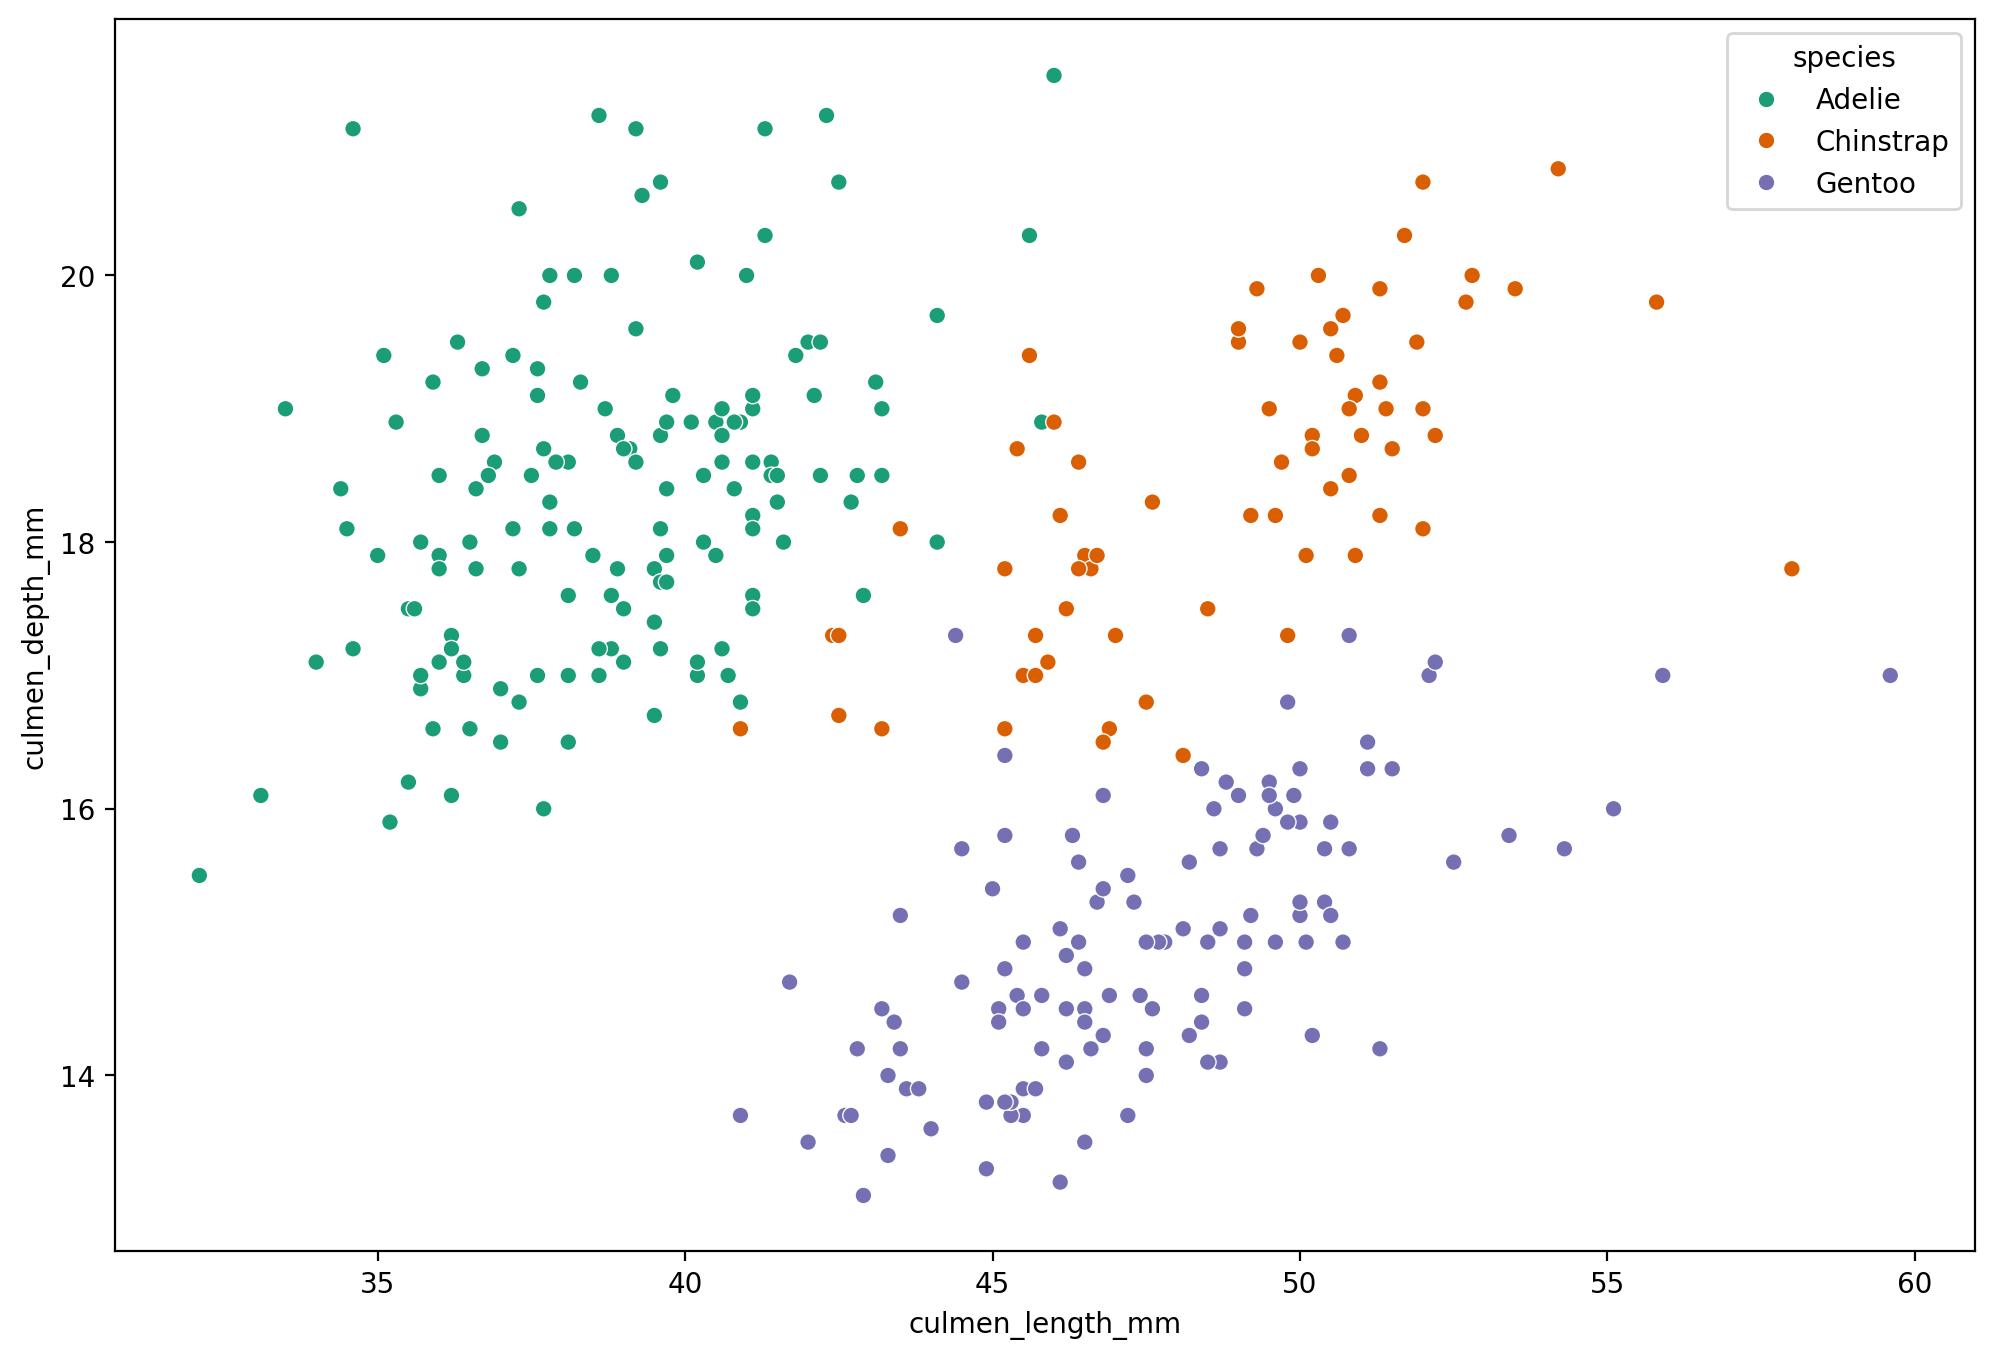

In [50]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=df, x='culmen_length_mm', y='culmen_depth_mm', hue='species', palette='Dark2')
plt.show()

<Figure size 2400x1600 with 0 Axes>

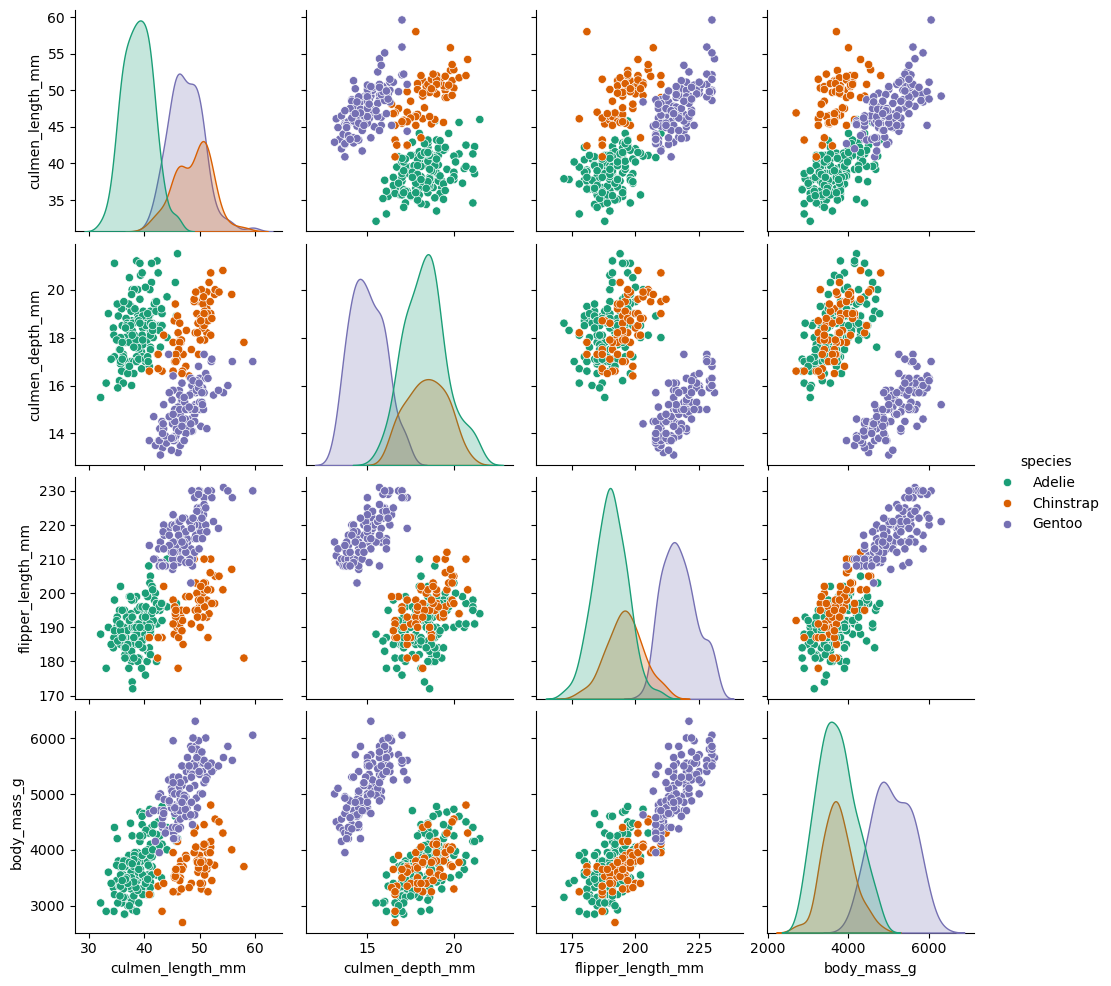

In [52]:
plt.figure(figsize=(12, 8), dpi=200)
sns.pairplot(data=df, hue='species', palette='Dark2')
plt.show()

Для некоторых признаков можно получить достаточно хорошее разделение на два класса. Для других признаков - классы пересекаются, но в целом видно, что возможность разделения классов есть.

C:\Users\chern\AppData\Local\Temp\ipykernel_5096\2724077328.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=df, x='species', y='culmen_length_mm', kind='box', col='sex', palette='Dark2')


<Figure size 2400x1600 with 0 Axes>

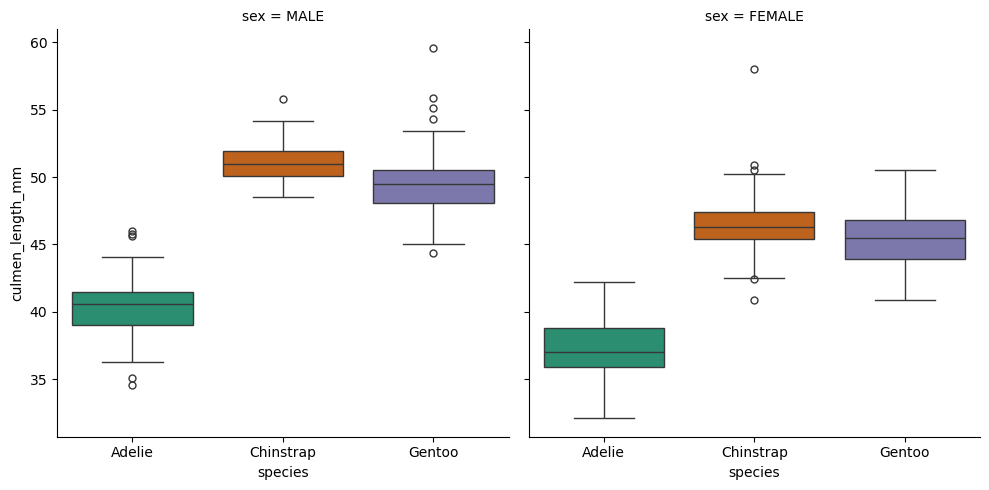

In [57]:
plt.figure(figsize=(12, 8), dpi=200)
sns.catplot(data=df, x='species', y='culmen_length_mm', kind='box', col='sex', palette='Dark2')
plt.show()

<Figure size 2400x1600 with 0 Axes>

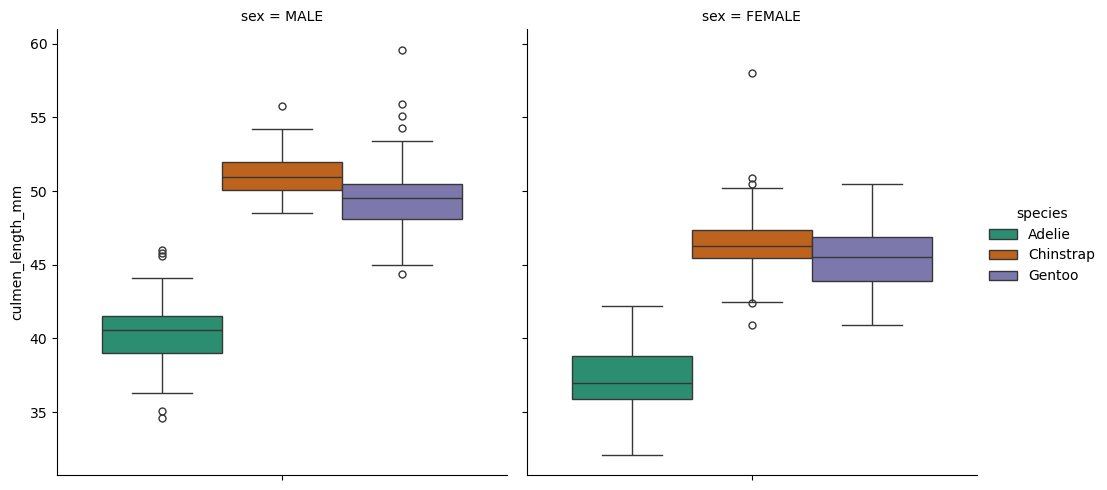

In [63]:
plt.figure(figsize=(12, 8), dpi=200)
sns.catplot(data=df, y='culmen_length_mm', hue='species', kind='box', col='sex', palette='Dark2')
plt.show()

## Построение признаков - Feature Engineering

Если посмотреть на признак *island* - он содержит несколько текстовых категорий.

In [67]:
df['island']

0      Torgersen
1      Torgersen
2      Torgersen
4      Torgersen
5      Torgersen
         ...    
338       Biscoe
340       Biscoe
341       Biscoe
342       Biscoe
343       Biscoe
Name: island, Length: 334, dtype: object

In [75]:
# Проще всего будет сразу передать весь датафрейм
X = pd.get_dummies(df.drop('species', axis=1), drop_first=True, dtype=int)
X.head()

culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
0              39.1             18.7              181.0       3750.0   
1              39.5             17.4              186.0       3800.0   
2              40.3             18.0              195.0       3250.0   
4              36.7             19.3              193.0       3450.0   
5              39.3             20.6              190.0       3650.0   

   island_Dream  island_Torgersen  sex_MALE  
0             0                 1         1  
1             0                 1         0  
2             0                 1         0  
4             0                 1         0  
5             0                 1         1

Таким образом дамми-переменные получены для колонок *island* и *sex*, колонку целевой переменной *species* можно оставить в текстовом виде. Признаки с непрерывными числовыми значениями остаются без изменений. Парметр drop_first=True нам нужен для того, чтобы избежать дублирования колонок.

In [79]:
y = df['species']

В отличие от других алгоритмов машинного обучения, в деревьях решений, в корневом узле, происходит сравнение по какому-то из признаков - равен ли этот признак какому-то значению или этот признак меньше или равен какого-то значения. 

Это значит, что можно не выполнять масштабирование признаков по той причине, что не будет использоваться несколько признаков одновременно. В каждом конкретном условии, в каждом конкретном узле - будет участвовать только один признак, поэтому не важно, если какой-то признак имеет шкалу значений, существенно отличающуюся от шкалы значений для других признаков.

## Разбиение на обучающий и тестовый наборы данных - Train | Test Split

In [84]:
from sklearn.model_selection import train_test_split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Классификатор "Дерево решений" - Decision Tree Classifier

## Гиперпараметры по умолчанию

### Построение модели

In [90]:
from sklearn.tree import DecisionTreeClassifier

In [92]:
model = DecisionTreeClassifier()

In [94]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [96]:
base_preds = model.predict(X_test)

In [98]:
base_preds

array(['Chinstrap', 'Gentoo', 'Adelie', 'Chinstrap', 'Gentoo',
       'Chinstrap', 'Adelie', 'Gentoo', 'Chinstrap', 'Gentoo', 'Adelie',
       'Adelie', 'Adelie', 'Gentoo', 'Gentoo', 'Adelie', 'Gentoo',
       'Adelie', 'Adelie', 'Adelie', 'Gentoo', 'Chinstrap', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Chinstrap', 'Gentoo', 'Adelie',
       'Chinstrap', 'Gentoo', 'Adelie', 'Gentoo', 'Adelie', 'Adelie',
       'Chinstrap', 'Adelie', 'Gentoo', 'Chinstrap', 'Gentoo', 'Adelie',
       'Adelie', 'Gentoo', 'Adelie', 'Adelie', 'Chinstrap', 'Chinstrap',
       'Chinstrap', 'Chinstrap', 'Chinstrap', 'Adelie', 'Adelie',
       'Gentoo', 'Gentoo', 'Adelie', 'Adelie', 'Chinstrap', 'Chinstrap',
       'Gentoo', 'Adelie', 'Chinstrap', 'Gentoo', 'Adelie', 'Adelie',
       'Adelie', 'Gentoo', 'Chinstrap', 'Chinstrap', 'Gentoo', 'Gentoo',
       'Gentoo', 'Gentoo', 'Gentoo', 'Gentoo', 'Gentoo', 'Gentoo',
       'Gentoo', 'Gentoo', 'Adelie', 'Gentoo', 'Adelie', 'Adelie',
       'Gentoo', 'Adelie'

### Оценка работы модели

In [102]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [104]:
print(classification_report(y_test, base_preds))

              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        41
   Chinstrap       1.00      0.96      0.98        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.99       101
   macro avg       0.99      0.99      0.99       101
weighted avg       0.99      0.99      0.99       101



В целом, модель с гиперпараметрами по умолчанию, работает достаточно хорошо. Можно отметить хорошие значения для метрик precision, recall и accuracy.

Такой результат является вполне ожидаемым, так как на этапе визуализации было видно достаточно хорошее разделение данных на отдельные классы.

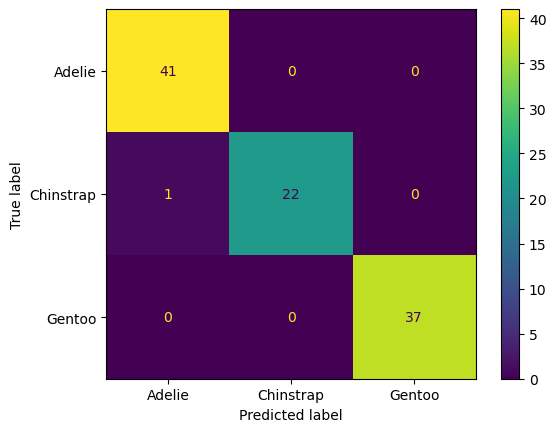

In [108]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

Видим, что всего один пингвин был классифицирован неправильно.

In [111]:
model.feature_importances_

array([0.33609286, 0.05366774, 0.53120101, 0.01085298, 0.0681854 ,
       0.        , 0.        ])

В данном атрибуте видно важность отдельных признаков. Значения перечислены в том же порядке, что и признаки.

In [116]:
pd.DataFrame(index=X.columns, data=model.feature_importances_, columns=['Важность признаков']).sort_values('Важность признаков')

Важность признаков
sex_MALE                     0.000000
island_Torgersen             0.000000
body_mass_g                  0.010853
culmen_depth_mm              0.053668
island_Dream                 0.068185
culmen_length_mm             0.336093
flipper_length_mm            0.531201

При построении дерева может оказаться так, что некоторые признаки практически не используются по той причине, что до них просто не доходит дело при построении дерева.

Можно, конечно, сделать так, чтобы дерево рассматривало как можно больше признаков, но тогда, в большинстве случаев, получится слишком большое дерево, которое скорее всего окажется переобученным.

[]

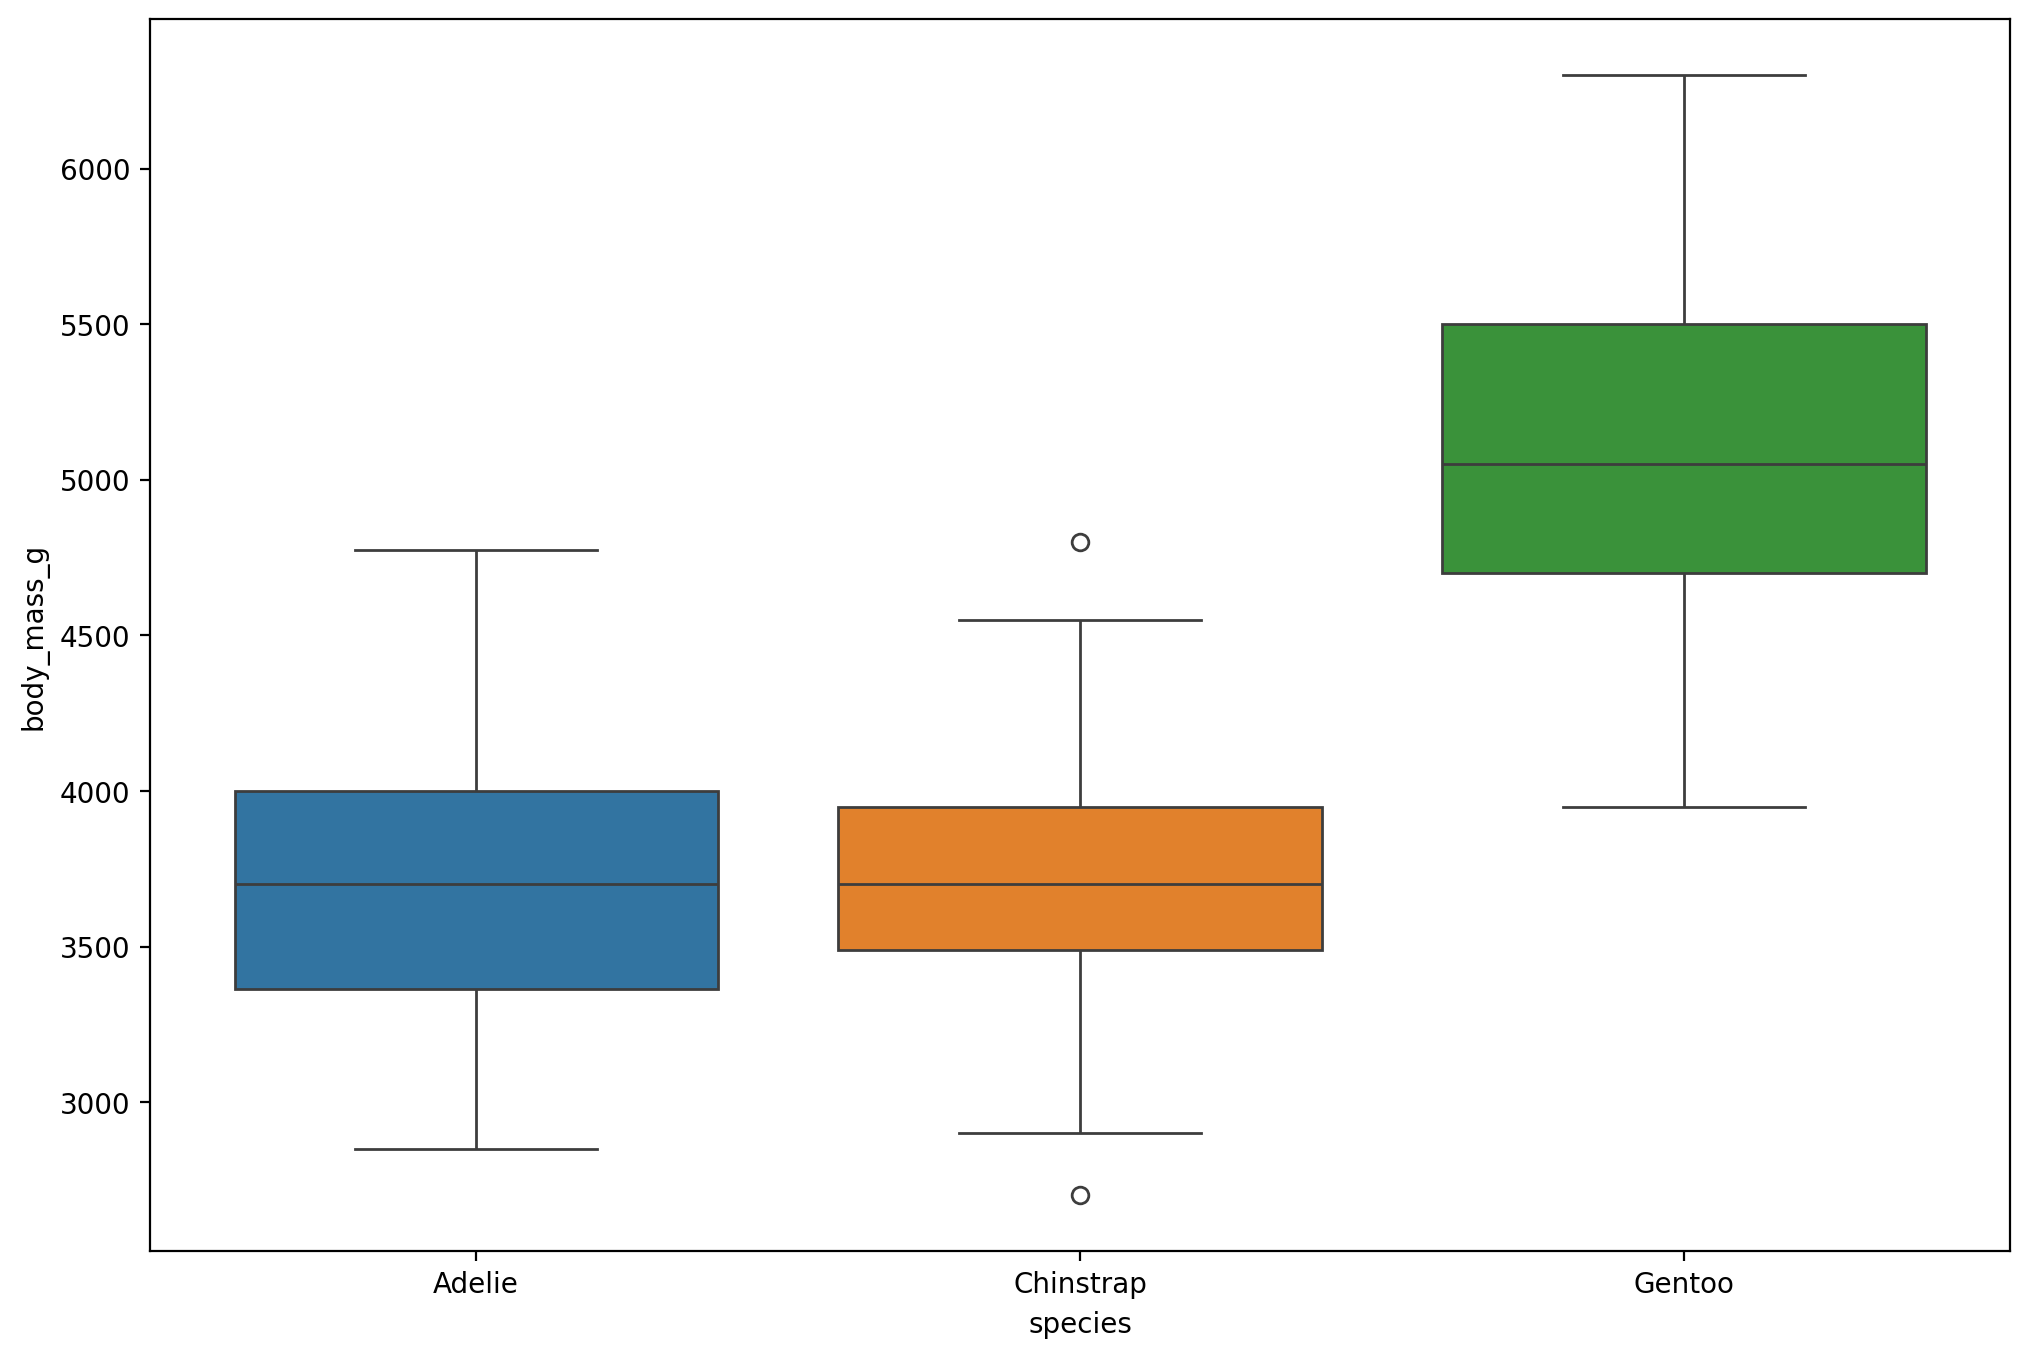

In [119]:
plt.figure(figsize=(12, 8), dpi=200)
sns.boxplot(data =df, x='species', y='body_mass_g', hue='species')
plt.plot()

### Визуализация дерева
Можно подробнее почитать [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).

In [123]:
from sklearn.tree import plot_tree

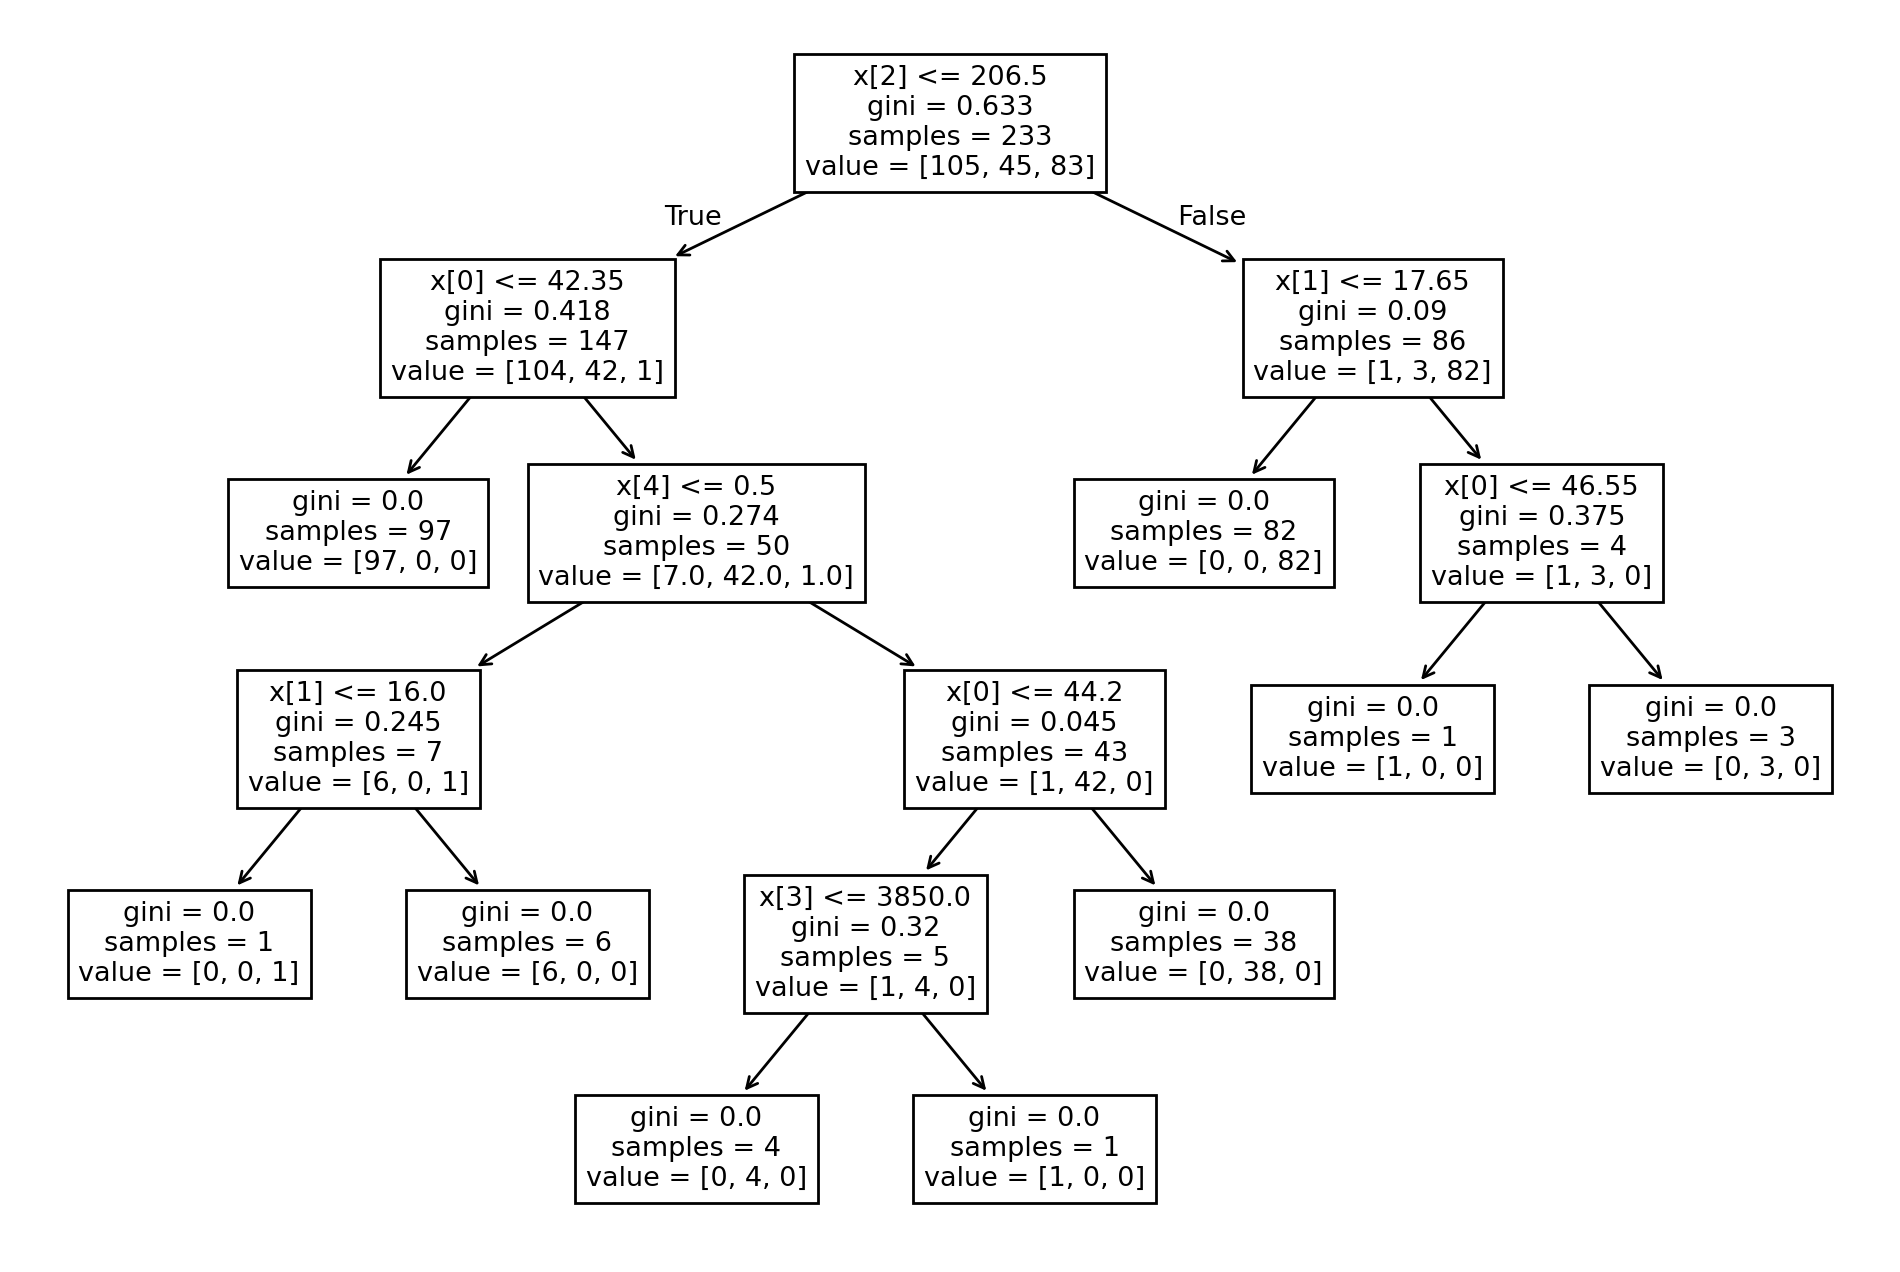

In [129]:
plt.figure(figsize=(12, 8), dpi=200)
plot_tree(model)
plt.show()

**Важно: с помощью изменения гиперпараметров можно построить другое дерево, в котором будет совершенно другая картина.**

На графике можно отображать не номера признаков, а их названия с помощью параметра `'feature_names=X.columns'`. Ещё одним полезным параметром является `filled=True` - он раскрашивает узлы разными цветами. Цвета назначаются следующим образом - у нас задача классификации с тремя классами, поэтому здесь количество цветов тоже равно трём - оранжевый, фиолетовый и зелёный. Тот или иной узел раскрашивается цветом в зависимости от того, значения какого из трёх классов в этом узле имеет наибольшее количество точек. Кроме того цвета бывают более тёмными или более светлыми - более тёмный цвет означает большую однородность значений, когда подавляющее большинство точек принадлежит к какому-то одному классу, поэтому в самом начале дерева наблюдаются достаточно светлые цвета, потому что однородность ещё очень небольшая, а по мере продвижения вниз, цвета становятся более тёмными.

Посмотрим на корневой узел: 
1. Условие x[2] <= 206.5 - условие разбиения в узле - берётся признак с индексом 2, причём, так как индексация начинается с 0 - это третий признак *flipper_length_mm* - он как раз является признаком с наибольшей важностью для данного дерева
2. Метрика "gini impurity"
3. samples - количество точек, которое пришло на вход в этот узел(здесь оно будет равно числу `len(X_train)`). Далее данные распределяются по отдельным веткам этого дерева. В левой части получилось 147 точек, а в правой - 86.
4. value - список из трёх значений - сколько точек принадлежит к каждому из трёх классов целевой переменной, если в листовом узле будет список значений, например [0, 0, 82] - это значит, что в этом листовом узле получено идеальное разделение данных - все точки принадлежат только к одному классу.

**Почему в корневом узле при выборе метрики Джини ее значение = 0.633.**

В sklearn применяется метрика индекс Джини (Gini Index), значения меняются от 0 до 1. Смысл практически тот же самый - ближе к 0 более чистое разбиение, ближе к 1 более смешанное.  
Какая метрика выбирается в корневом узле - выбирается та метрика, которая позволяет лучше других метрик разбить данные c точки зрения Gini Impurity / Gini Index. 

Метрика Джини может принимать значение от 0 до 0.5 для двух классов. Если же классов больше, то значения Gini могут быть больше.  
Чтобы разобраться в этом, вспомним формулу для метрики Gini Impurity:  мы суммируем по всем классам произведение двух слагаемых: $p_k * (1 - p_k)$. 

В лекции был пример для двух классов - красный и синий - и приводился пример с 4 точками.  
А представим теперь, что у нас три класса - красный, синий и зелёный - и 9 точек:
* Если все точки принадлежат к одному классу, например красному, то для красного цвета будет 9/9 * (1-9/9) = 0, а для синего и зелёного классов будет 0/9 * (1-0/9) = 0.  Суммируя по всем трём классам, получаем 0+0+0=0.  Так что для полностью однородного случая Джини=0, как и должно быть.
* Если же все точки принадлежат к разным классам - из 9 точек 3 красных, 3 синих и 3 зелёных (то есть, "наиболее смешанный случай") - то для каждого из трёх цветов будет 3/9 * (1-3/9) = 3 * 6 / 81 = 18 / 81 = 0.22 для каждого класса.  Суммируем по трём классам:  0.22 + 0.22 + 0.22 = 0.66

Если развивать эту тему дальше, то чем больше количество классов, тем Gini для "наиболее смешанного случая" всё ближе приближается к 1.  В качестве примера для количества классов К возьмём $К*К$ точек, тогда наиболее смешанный случай - это когда каждый класс имеет одинаковое количество точек, равное К.  Для одного класса Gini будет равно $k / (k*k) * (1 - k/(k*k))$.  И дальше это нужно просуммировать по всем классам, то есть умножить на К, потому что все слагаемые в данном случае одинаковые.

В итоге для разных К получается следующее:

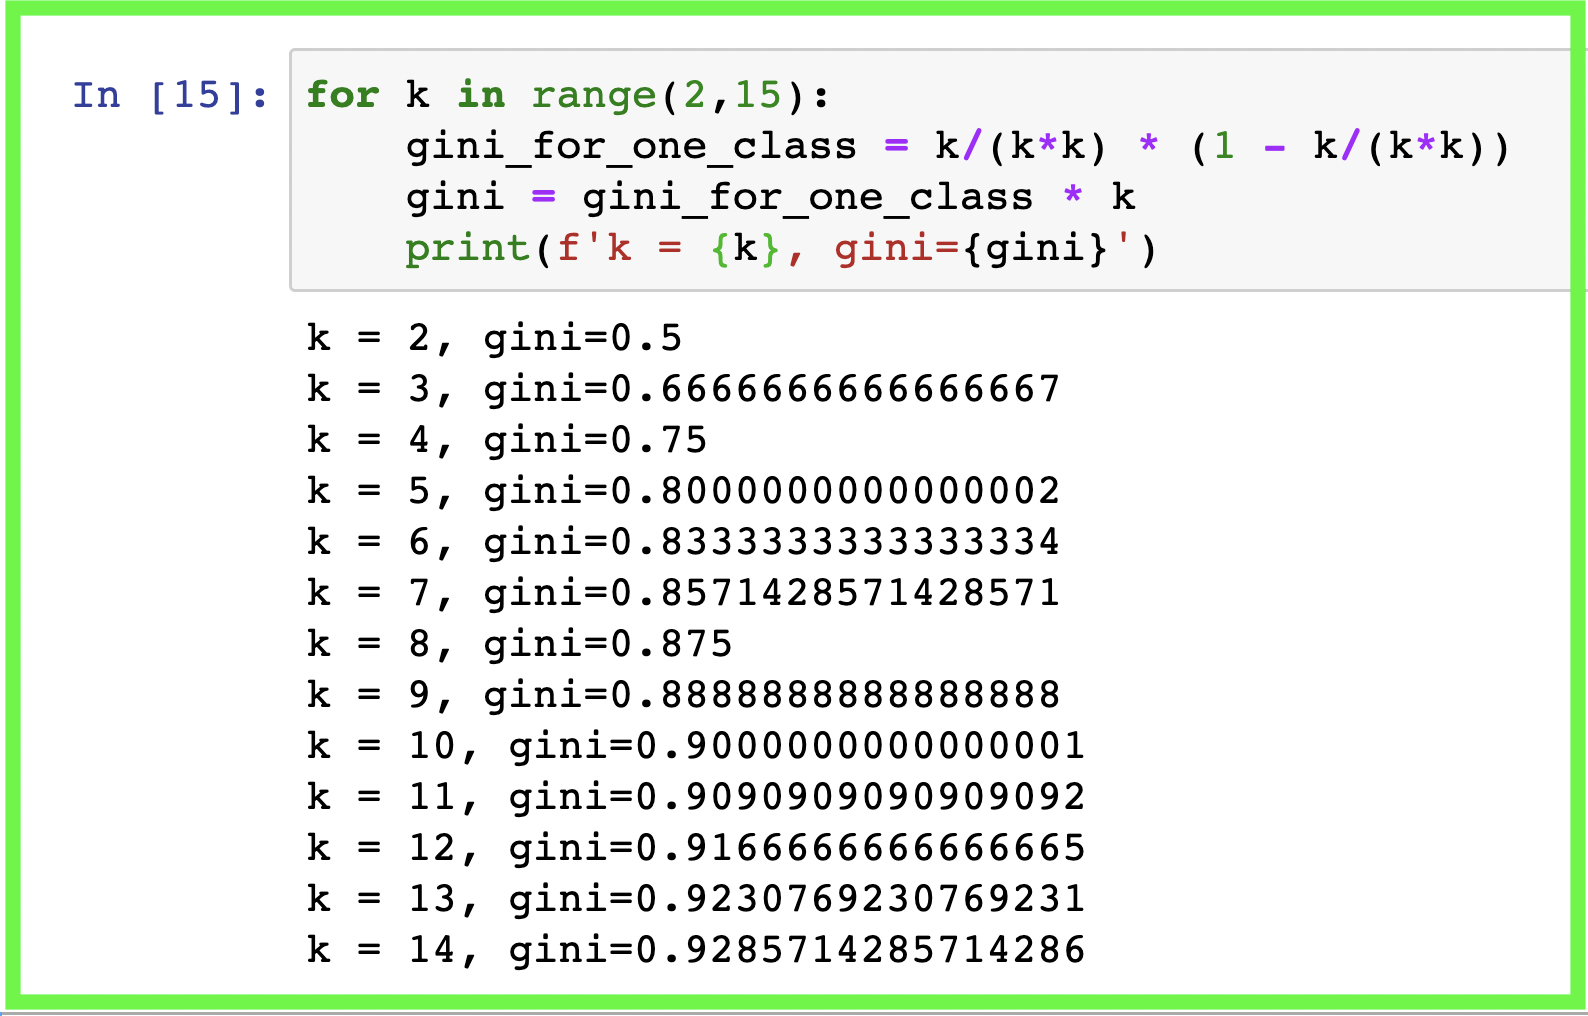

В конечном итоге общий вывод - метрика Gini Impurity меняется от 0 до 1. Близкие к 0 значения означают более чистое разбиение, а близкие к 1 значения означают более смешанное разбиение.

Для полноты картины также надо отметить, что иногда формулу для Gini "мы суммируем по всем классам произведение двух слагаемых: $p_k * ( 1 - p_k )$" ещё можно увидеть в альтернативном виде. Eсли раскрыть скобки, то получим сумму по всем классам выражения $( p_k - p_k*p_k )$.  Суммируя первое слагаемое $p_k$ по всем классам, получаем 1, потому что сумма всех вероятностей равна 1. В итоге альтернативная формула выглядит так: **"Единица минус сумма по всем классам $p_k*p_k$"**.

Особенность этих диаграмм состоит в том, что здесь в узлах указана метрика gini impurity только перед(!) очередным разбиением данных. Какое значение gini impurity будет после разбиения - а именно это мы минимизируем! - указано не в самом узле, а в узлах чуть ниже, уже после разбиения.

В данном примере gini = 0.633 в корневом узле - это значение метрики gini перед(!) разбиением "flipper_length_mm <= 206.5".  У нас есть 233 точки с данными (samples = 233) и их разбиение на три класса: value = [105, 45, 83].  Посчитаем метрику gini по формуле "сумма по всем классам произведения $p_k * ( 1 - p_k )$", получим  105/233 * (1 - 105/233) + 45/233 * (1 - 45/233) + 83/233 * (1 - 83/233) = 0.6327248613899684, округляем до 0.633.

Если мы поменяем условие "flipper_length_mm <= 206.5" на какое-то другое условие, то значение gini = 0.633 останется тем же самым, а поменяются gini=0.418 и gini=0.09 в двух следующих узлах.

Чисто теоретически - да, можно было бы на каждом узле дополнительно указывать, насколько разбивающее условие меняет метрику gini impurity. То есть, указывать не только значение на входе, но и значения на выходе и/или изменение метрики gini impurity - насколько разбивающее условие уменьшает метрику gini impurity. Но здесь везде отображается только "значение на входе", то есть, перед очередным разбиением данных.

Для разделённых данных выполняется всё то же самое, что и для корневого узла, но уже применительно к тем данным, которые попадают в ту или иную ветку дерева.

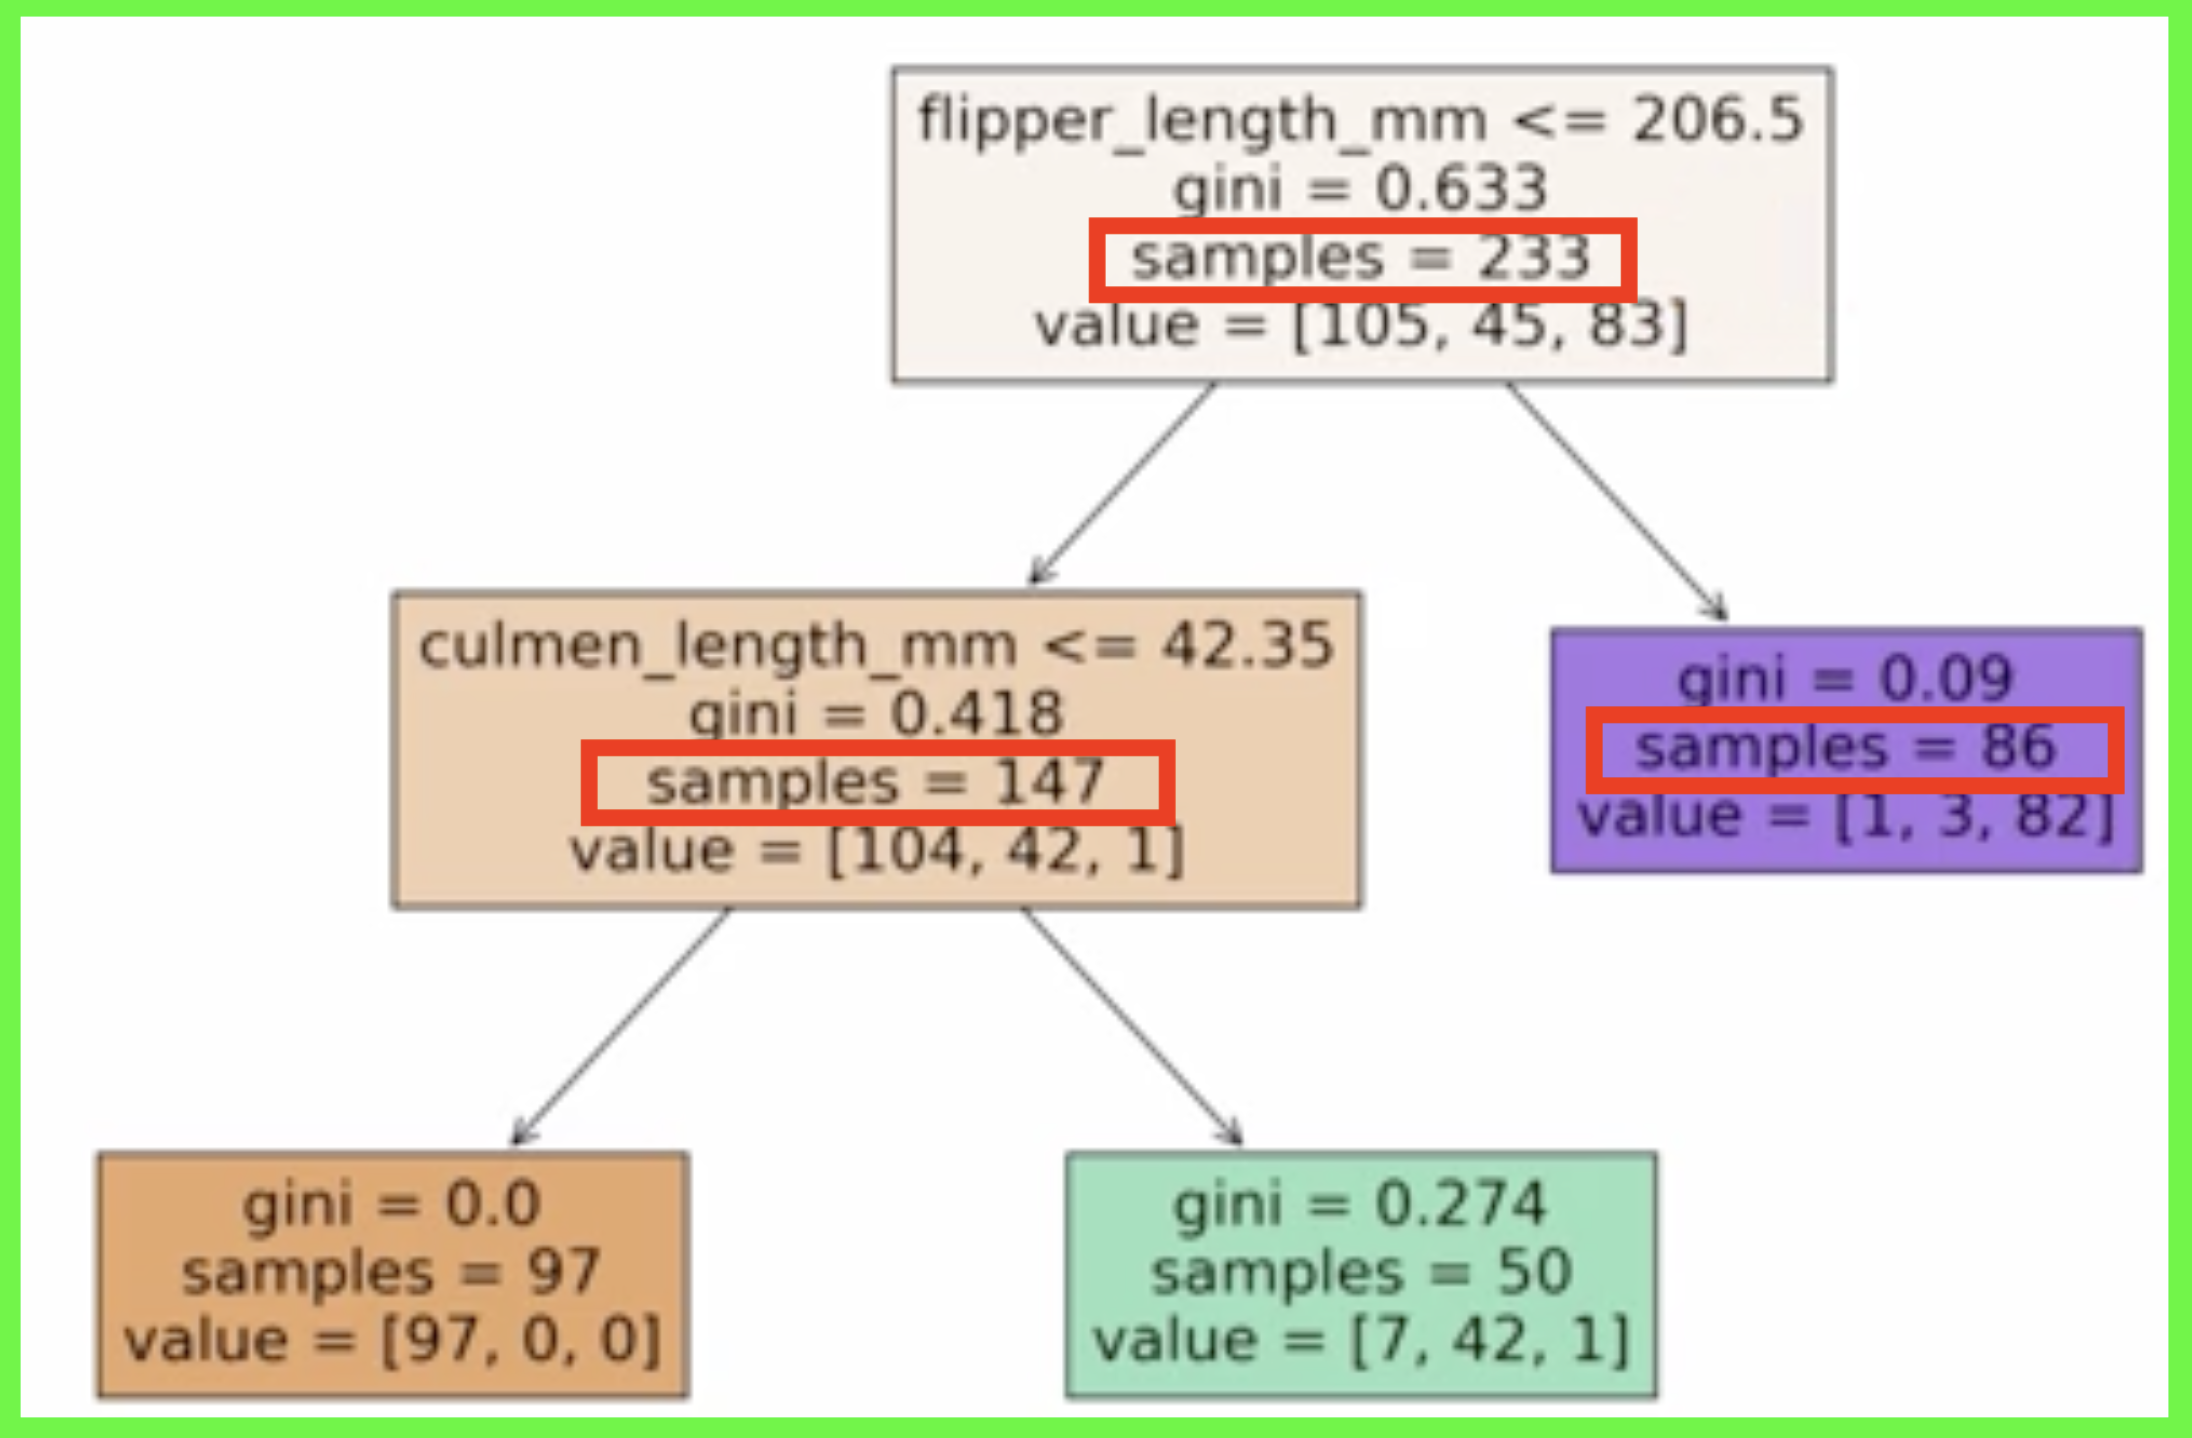

В самом начале у нас 233 строк, в корневом узле дерева мы видим samples=233. Далее, после того как мы определились с тем, какое лучше сделать разбиение данных в этом корневом узле, мы разбиваем данные - какие-то данные попадают в одну ветку дерева, слева (samples=147), а какие-то данные попадают в другую ветку справа (samples=86). Далее к каждой из этих двух веток применяется такой же алгоритм, который применялся ранее для корневого узла.

Могут ли признаки дублироваться? Формально, в самом общем алгоритме построения деревьев решений, признаки "не выбывают из игры" после того, как был выбран тот или иной признак. Поэтому да - признаки могут дублироваться. Однако будут ли они дублироваться - зависит от конкретных данных. В разных ветках - возможно. Однако в одной и той же ветке - маловероятно, ведь всё-таки скорее всего найдётся какой-то другой признак, который несёт больше информации для разделения данных, и он будет выбран в качестве разделяющего признака.

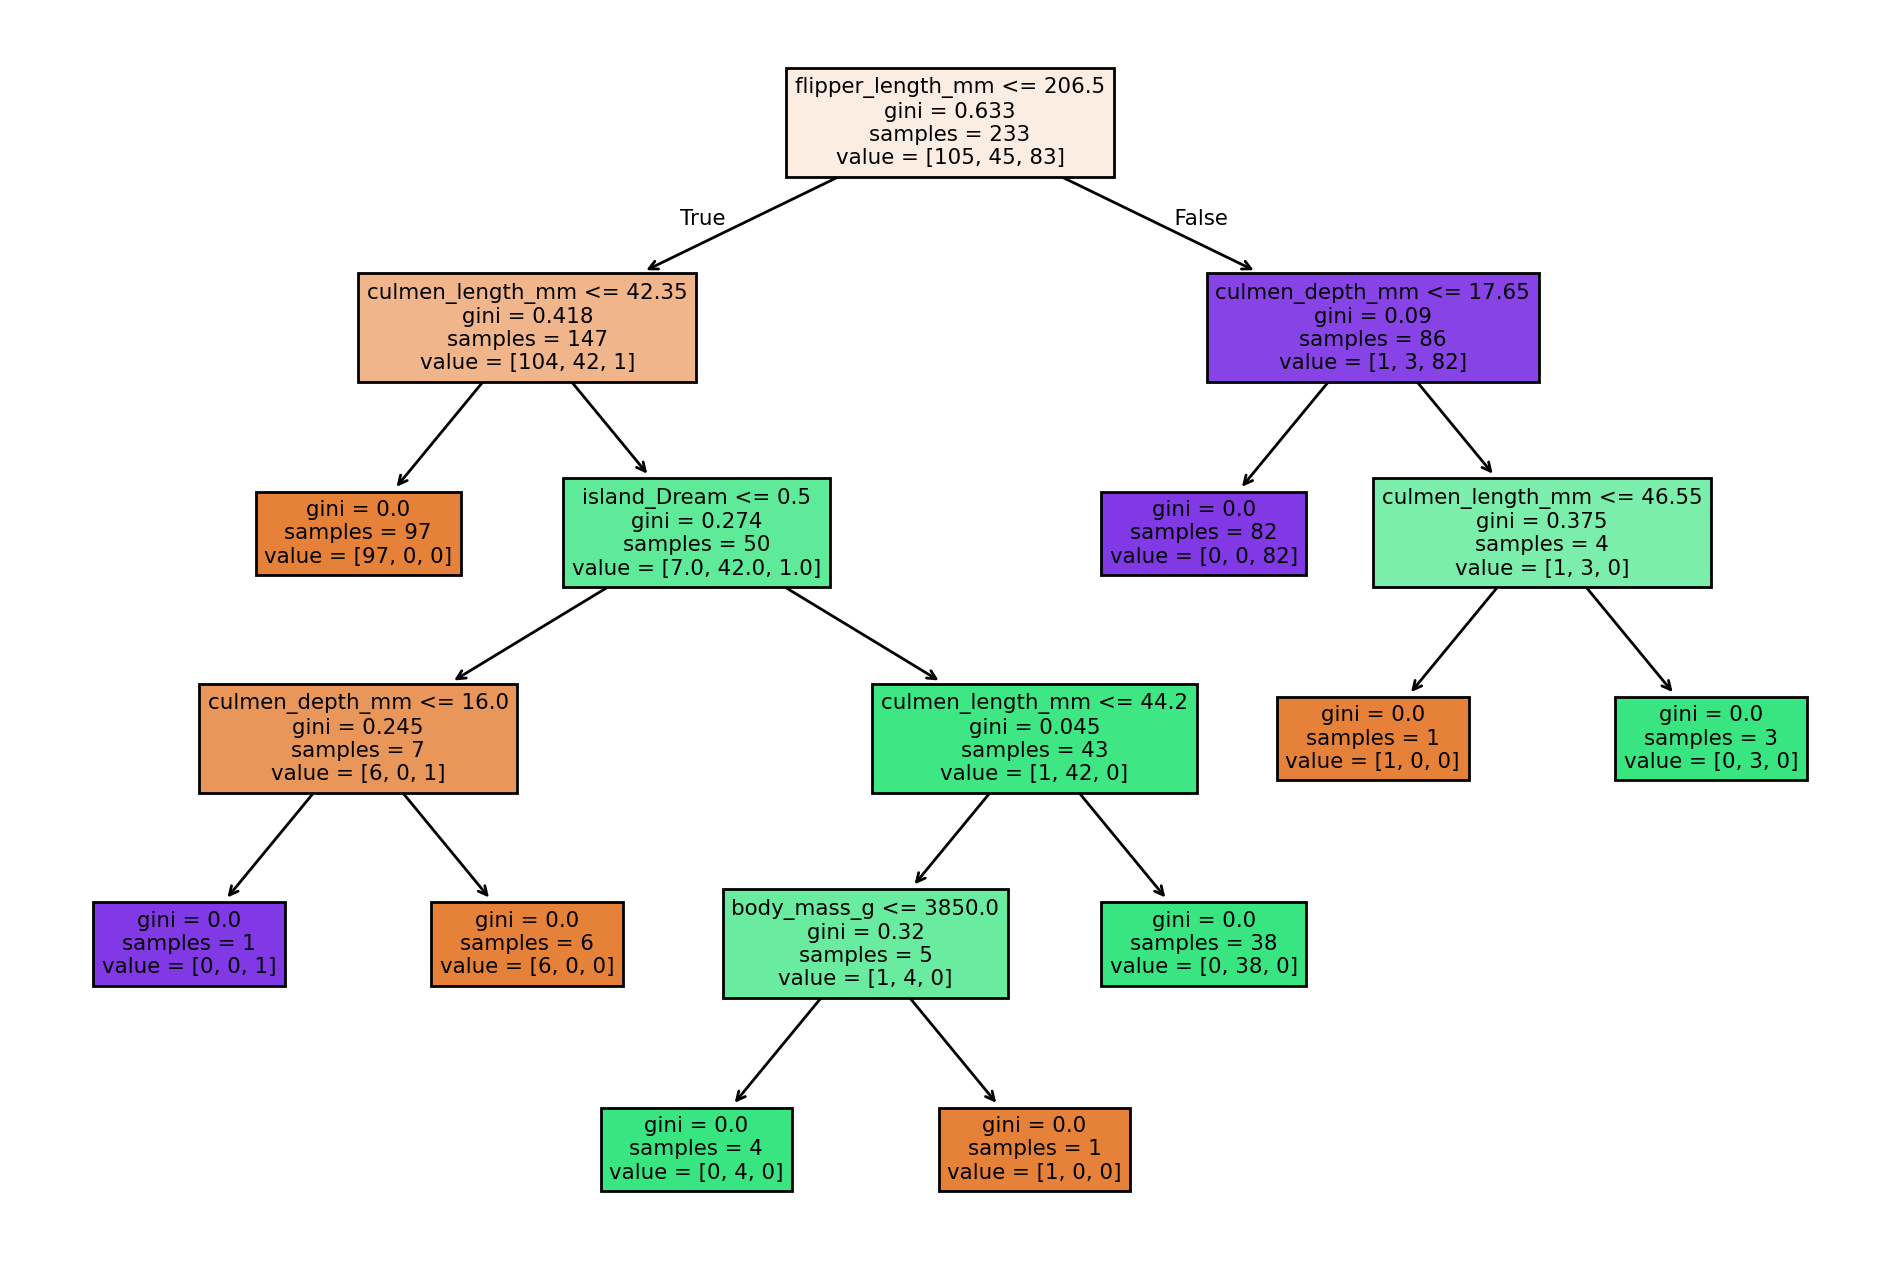

In [131]:
plt.figure(figsize=(12, 8), dpi=200)
plot_tree(model, feature_names=X.columns, filled=True)
plt.show()

## Гиперпараметры

### Результаты модели
Чтобы поэкспериментировать с гиперпараметрами, создадим функцию, которая возвращает результаты классификации, а также рисует дерево.

In [184]:
def report_model(model):
    """Функция, которая возвращает результаты классификации, а также рисует дерево."""
    model_preds = model.predict(X_test)
    print(classification_report(y_test, model_preds))
    print('\n')
    plt.figure(figsize=(12, 8), dpi=200)
    plot_tree(model, feature_names=X.columns, filled=True)
    plt.show()

              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        41
   Chinstrap       1.00      0.96      0.98        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.99       101
   macro avg       0.99      0.99      0.99       101
weighted avg       0.99      0.99      0.99       101





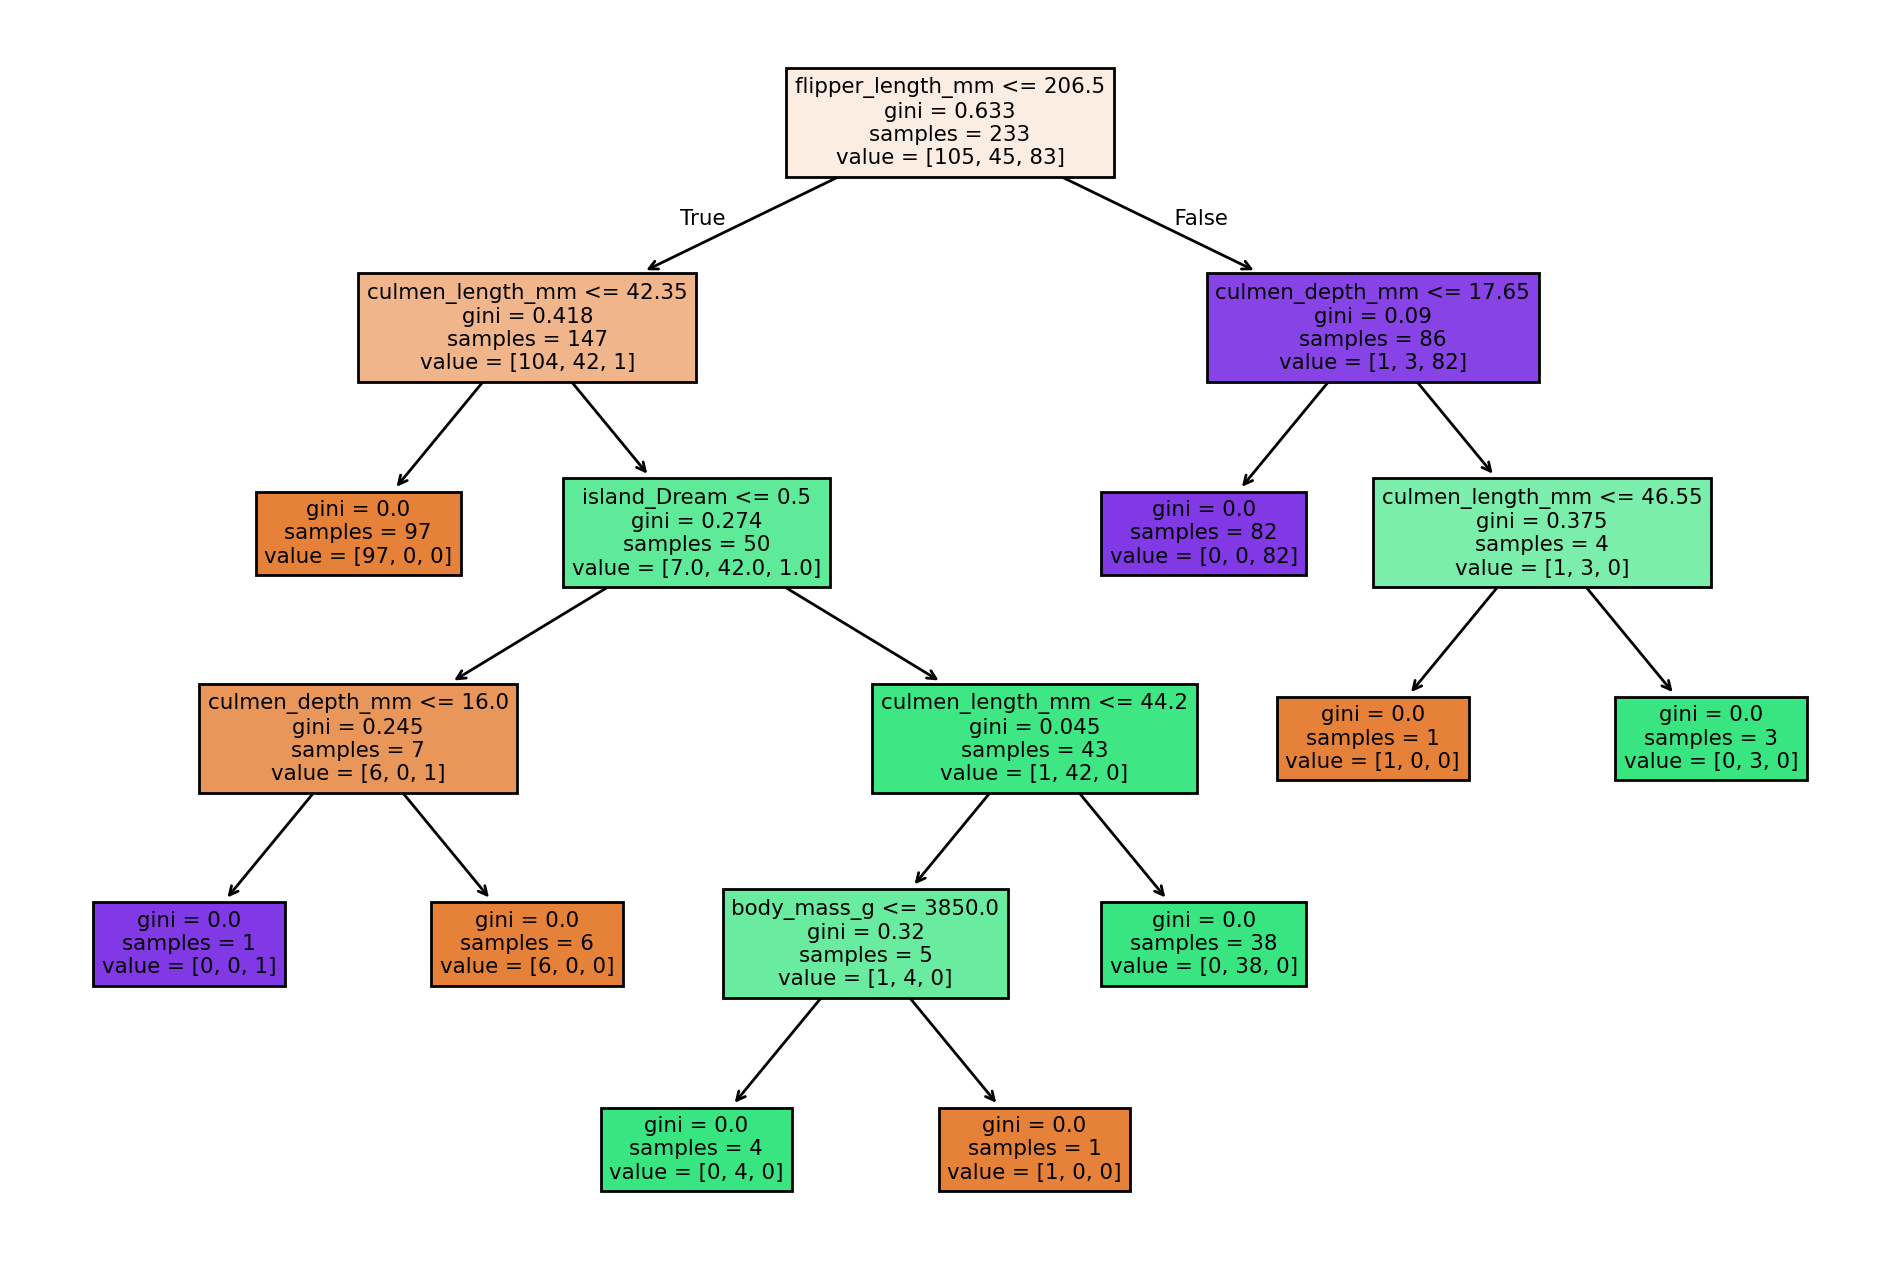

In [186]:
report_model(model)

In [151]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0, monotonic_cst=None)
 |
 |  A decision tree classifier.
 |
 |  Read more in the :ref:`User Guide <tree>`.
 |
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy", "log_loss"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "log_loss" and "entropy" both for the
 |      Shannon information gain, see :ref:`tree_mathematical_formulation`.
 |
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies ar

### Гиперпараметр "Max Depth"

In [154]:
pruned_tree = DecisionTreeClassifier(max_depth=2)
pruned_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

              precision    recall  f1-score   support

      Adelie       0.97      0.88      0.92        41
   Chinstrap       0.81      0.96      0.88        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.94       101
   macro avg       0.93      0.94      0.93       101
weighted avg       0.95      0.94      0.94       101





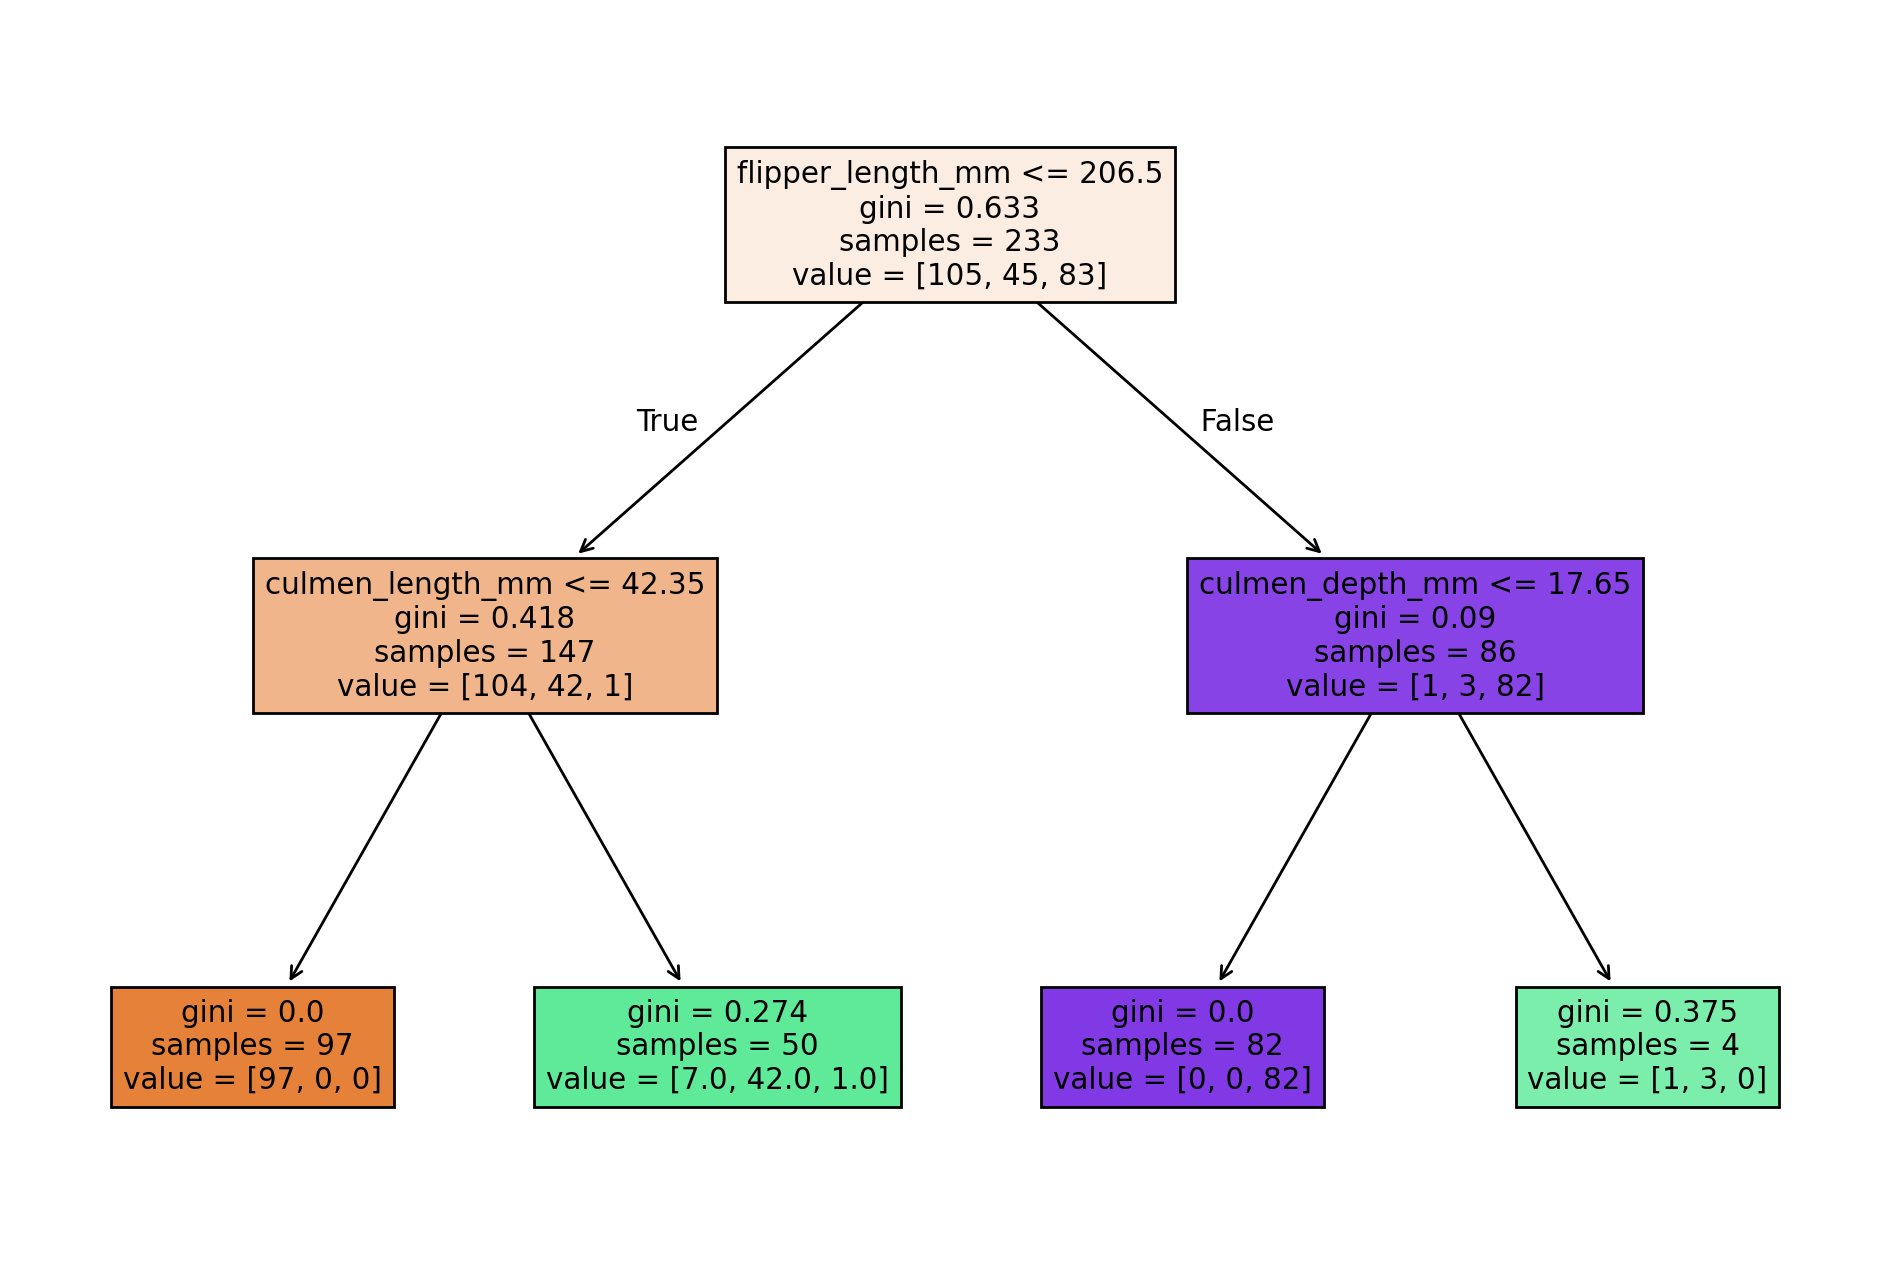

In [188]:
report_model(pruned_tree)

Здесь можно заметить уменьшение точности работы модели, однако и дерево решений, в данном случае, получилось заметно проще. Здесь у нас только два уровня разбиения данных - корневой и один уровень после него, всё что далее - это уже листовые узлы.

Если указать какое-то больше количество уровней разбиения, например 15 - это вовсе не значит что дерево будет содержать 15 уровней разбиения. Здесь всего лишь устанавливается верхний лимит на количество уровней, но он не обязательно будет достигнут.

По умолчанию дерево строится до тех пор, пока все узлы не станут однородными или пока не будет достигнуто значение параметра `min_samples_split` - минимальное количество точек для разбиения(по умолчанию равно 2).

### Гиперпараметр "Max Leaf Nodes"

Так как у нас всего три класса, значение max_leaf_nodes=3 - это экстримально малое значение - по одному узлу на каждый класс для целевой переменной.

In [164]:
max_leaf_tree = DecisionTreeClassifier(max_leaf_nodes=3)
max_leaf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3)

              precision    recall  f1-score   support

      Adelie       0.97      0.88      0.92        41
   Chinstrap       0.83      0.87      0.85        23
      Gentoo       0.93      1.00      0.96        37

    accuracy                           0.92       101
   macro avg       0.91      0.92      0.91       101
weighted avg       0.92      0.92      0.92       101





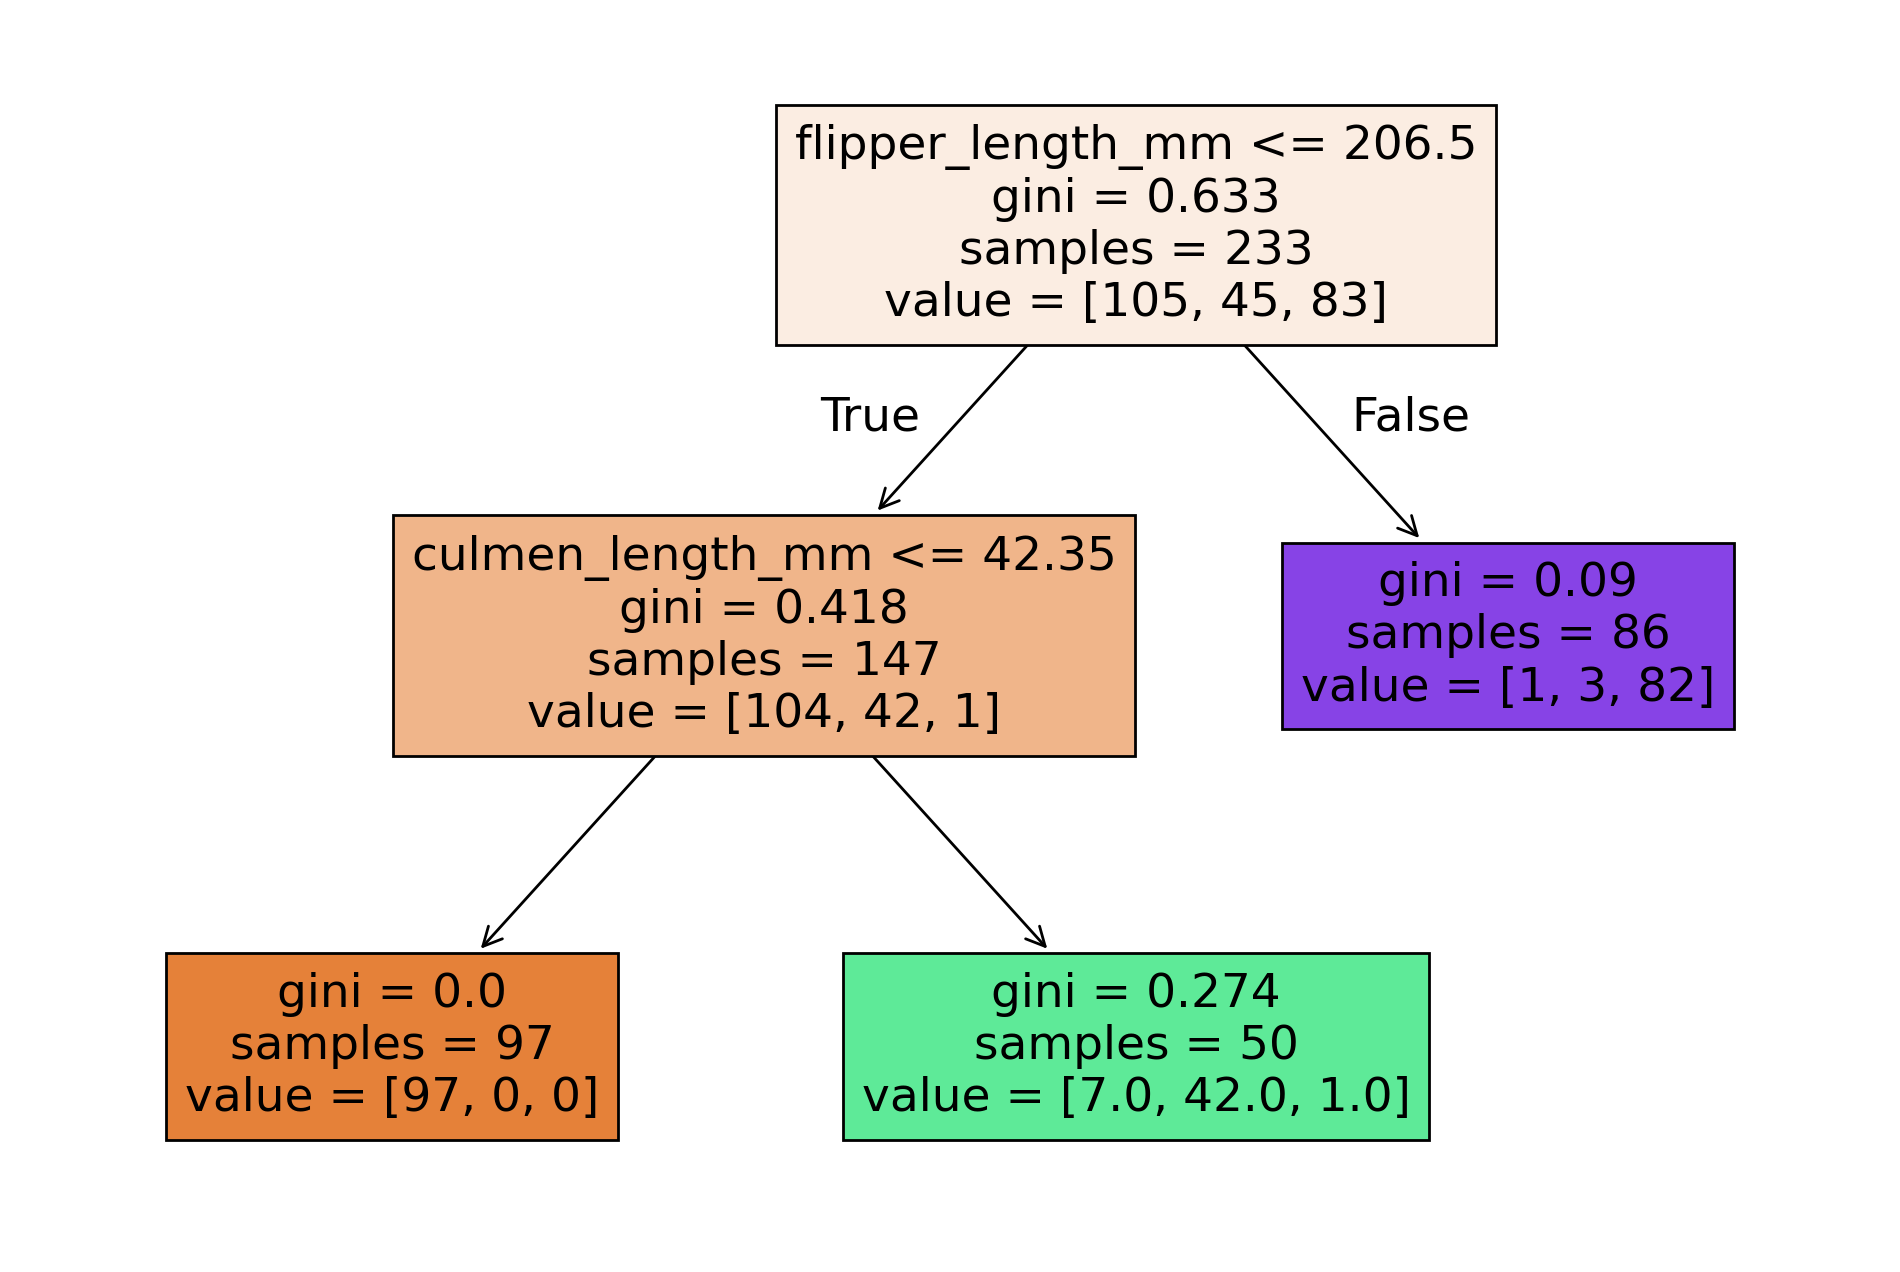

In [190]:
report_model(max_leaf_tree)

Мы также видим уменьшение точности модели, однако дерево получилось очень простым. Здесь было допущено всего три листовых узла и в итоге получено всего два разбиения. С учётом того, какая простая модель была построена - в ней всего два признака и два разбиения - результаты получились достаточно неплохими.

Получено минимально возможное количество листовых узлов для трёх классов, причём в одном из листовых узлов даже получились полностью однородные данные принадлежащие только к одному классу gini=0.

Неправильно классифицированных пингвинов получилось всего 12 из общего количества 233.

### Гиперпараметр "Criterion"
Для построения дерева, кроме метрики 'gini impurity', можно использовать метрику 'information gain'

In [196]:
entropy_tree = DecisionTreeClassifier(criterion='entropy')
entropy_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

              precision    recall  f1-score   support

      Adelie       0.91      0.95      0.93        41
   Chinstrap       0.90      0.83      0.86        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.94       101
   macro avg       0.94      0.93      0.93       101
weighted avg       0.94      0.94      0.94       101





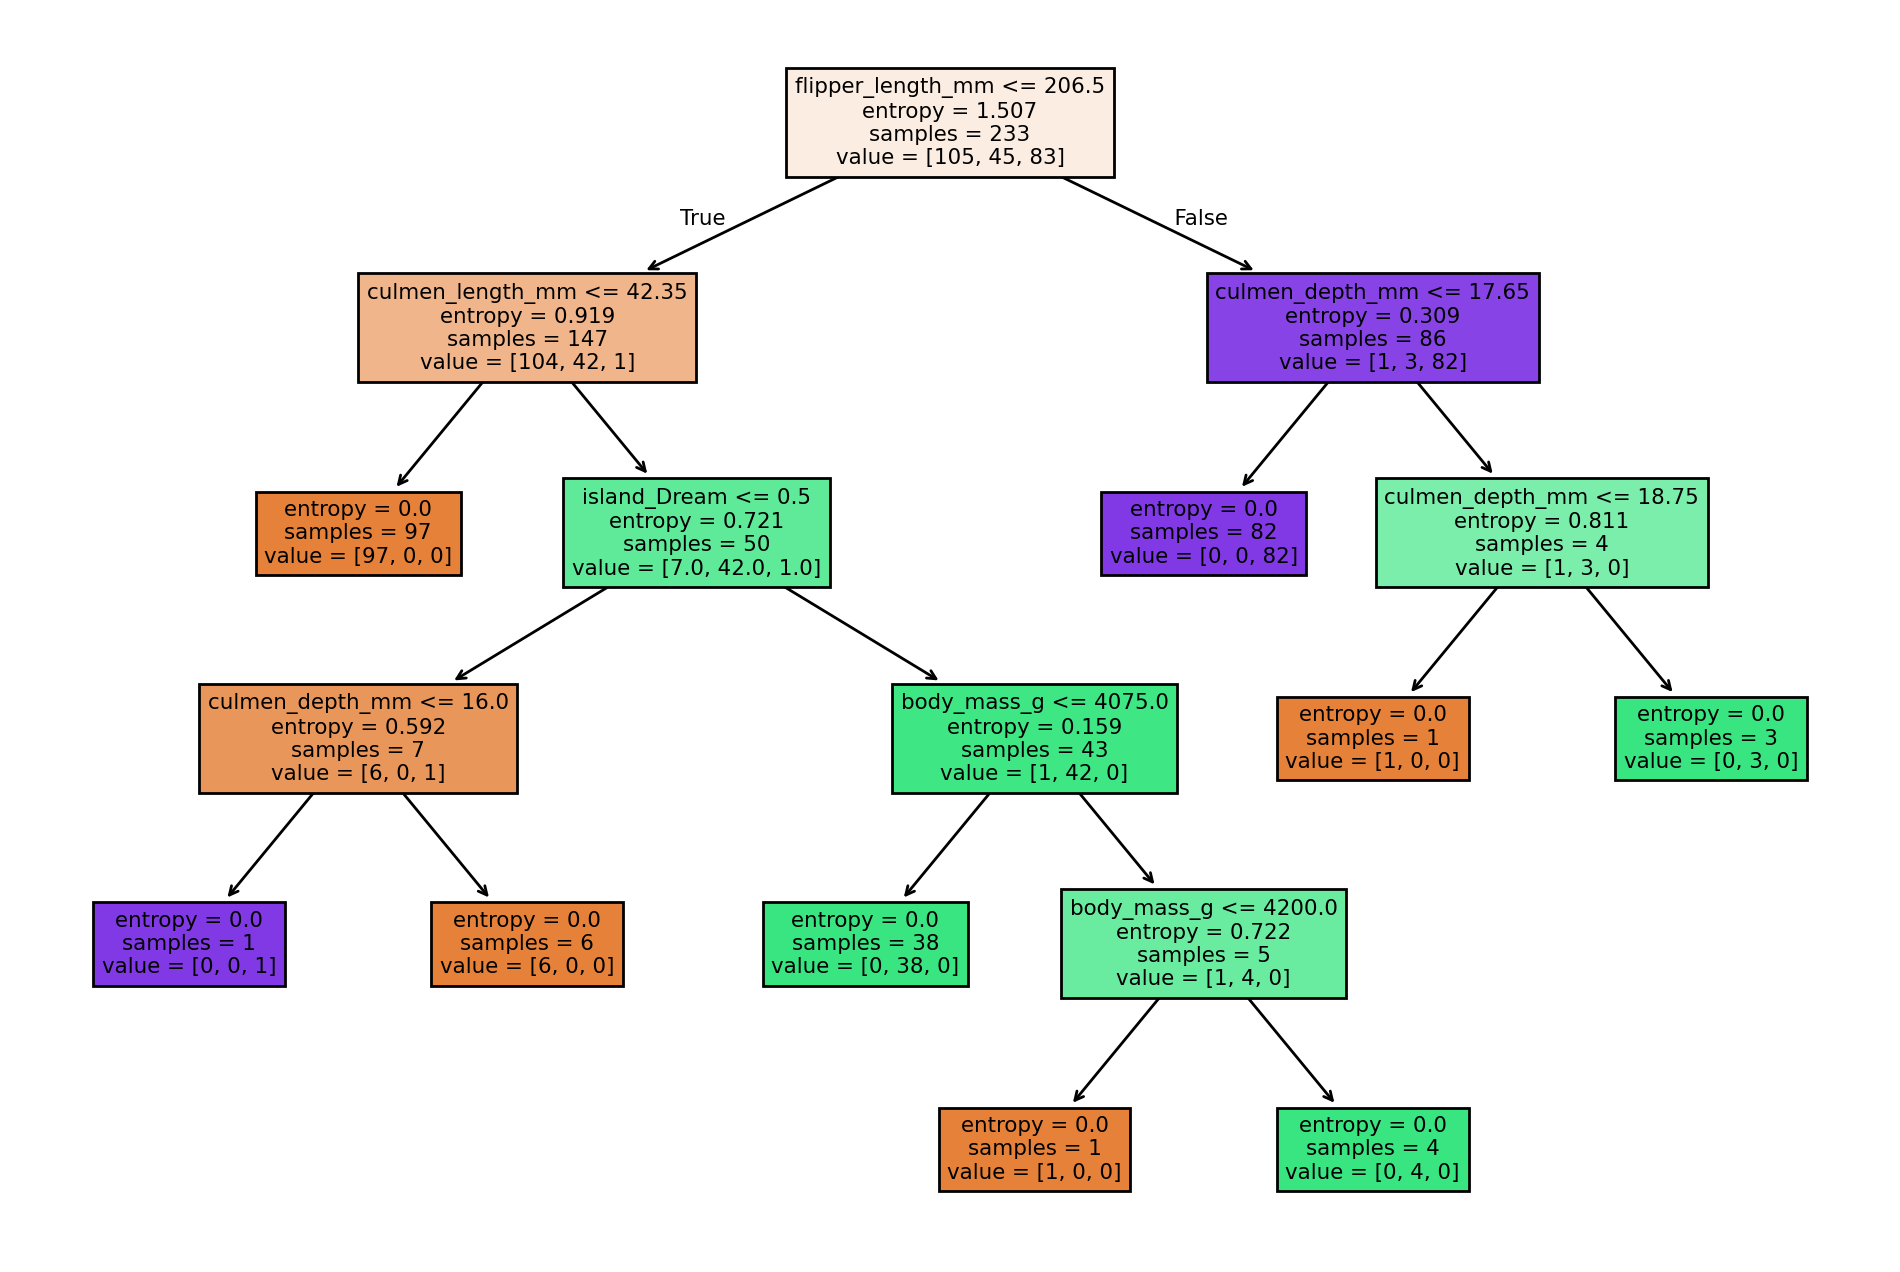

In [198]:
report_model(entropy_tree)

Здесь получились очень хорошие значения метрик. Полученное дерево выглядит очень похоже на первоначальное дерево, когда использовались значения параметров по умолчанию. Будут ли эти деревья отличаться или нет, зависит от конкретных данных.